# Order Delivery Time Prediction

## Objectives
The objective of this assignment is to build a regression model that predicts the delivery time for orders placed through Porter. The model will use various features such as the items ordered, the restaurant location, the order protocol, and the availability of delivery partners.

The key goals are:
- Predict the delivery time for an order based on multiple input features
- Improve delivery time predictions to optimiae operational efficiency
- Understand the key factors influencing delivery time to enhance the model's accuracy

## Data Pipeline
The data pipeline for this assignment will involve the following steps:
1. **Data Loading**
2. **Data Preprocessing and Feature Engineering**
3. **Exploratory Data Analysis**
4. **Model Building**
5. **Model Inference**

## Data Understanding
The dataset contains information on orders placed through Porter, with the following columns:

| Field                     | Description                                                                                 |
|---------------------------|---------------------------------------------------------------------------------------------|
| market_id                 | Integer ID representing the market where the restaurant is located.                         |
| created_at                | Timestamp when the order was placed.                                                        |
| actual_delivery_time      | Timestamp when the order was delivered.                                                     |
| store_primary_category    | Category of the restaurant (e.g., fast food, dine-in).                                      |
| order_protocol            | Integer representing how the order was placed (e.g., via Porter, call to restaurant, etc.). |
| total_items               | Total number of items in the order.                                                         |
| subtotal                  | Final price of the order.                                                                   |
| num_distinct_items        | Number of distinct items in the order.                                                      |
| min_item_price            | Price of the cheapest item in the order.                                                    |
| max_item_price            | Price of the most expensive item in the order.                                              |
| total_onshift_dashers     | Number of delivery partners on duty when the order was placed.                              |
| total_busy_dashers        | Number of delivery partners already occupied with other orders.                             |
| total_outstanding_orders  | Number of orders pending fulfillment at the time of the order.                              |
| distance                  | Total distance from the restaurant to the customer.                                         |


## **Importing Necessary Libraries**

In [14]:
# Install necessary libraries
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install statsmodels
!pip install scikit-learn

In [67]:
# Import essential libraries for data manipulation and analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#For Regression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error
from sklearn.feature_selection import RFE # Automated Feature Selection (Recursive Feature Elimination)
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats



## **1. Loading the data**
Load 'porter_data_1.csv' as a DataFrame

In [16]:
# Importing the file porter_data_1.csv
df = pd.read_csv('porter_data_1.csv')
df.head()

market_id           created_at actual_delivery_time  \
0        1.0  2015-02-06 22:24:17  2015-02-06 23:11:17   
1        2.0  2015-02-10 21:49:25  2015-02-10 22:33:25   
2        2.0  2015-02-16 00:11:35  2015-02-16 01:06:35   
3        1.0  2015-02-12 03:36:46  2015-02-12 04:35:46   
4        1.0  2015-01-27 02:12:36  2015-01-27 02:58:36   

   store_primary_category  order_protocol  total_items  subtotal  \
0                       4             1.0            4      3441   
1                      46             2.0            1      1900   
2                      36             3.0            4      4771   
3                      38             1.0            1      1525   
4                      38             1.0            2      3620   

   num_distinct_items  min_item_price  max_item_price  total_onshift_dashers  \
0                   4             557            1239                   33.0   
1                   1            1400            1400                    1.0   
2                   3             820            1604                    8.0   
3                   1            1525            1525                    5.0   
4                   2            1425            2195                    5.0   

   total_busy_dashers  total_outstanding_orders  distance  
0                14.0                      21.0     34.44  
1                 2.0                       2.0     27.60  
2                 6.0                      18.0     11.56  
3                 6.0                       8.0     31.80  
4                 5.0                       7.0      8.20

## **2. Data Preprocessing and Feature Engineering** <font color = red>[15 marks]</font> <br>

#### **2.1 Fixing the Datatypes**  <font color = red>[5 marks]</font> <br>
The current timestamps are in object format and need conversion to datetime format for easier handling and intended functionality

##### **2.1.1** <font color = red>[2 marks]</font> <br>
Convert date and time fields to appropriate data type

In [17]:
# Convert 'created_at' and 'actual_delivery_time' columns to datetime format
df['created_at'] = pd.to_datetime(df['created_at'])
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])
df.dtypes[['created_at', 'actual_delivery_time']]


created_at              datetime64[ns]
actual_delivery_time    datetime64[ns]
dtype: object

##### **2.1.2**  <font color = red>[3 marks]</font> <br>
Convert categorical fields to appropriate data type

In [18]:
# Convert categorical features to category type
categorical_columns = ['market_id', 'store_primary_category', 'order_protocol']
# Convert to 'category' dtype
for col in categorical_columns:
    df[col] = df[col].astype('category')

# Verify the data types
df.dtypes[categorical_columns]


market_id                 category
store_primary_category    category
order_protocol            category
dtype: object

#### **2.2 Feature Engineering** <font color = red>[5 marks]</font> <br>
Calculate the time taken to execute the delivery as well as extract the hour and day at which the order was placed

##### **2.2.1** <font color = red>[2 marks]</font> <br>
Calculate the time taken using the features `actual_delivery_time` and `created_at`

In [19]:
# Calculate time taken in minutes
df['delivery_time_minutes'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds() / 60

##### **2.2.2** <font color = red>[3 marks]</font> <br>
Extract the hour at which the order was placed and which day of the week it was. Drop the unnecessary columns.

In [20]:
# Extract the hour and day of week from the 'created_at' timestamp
df['order_hour'] = df['created_at'].dt.hour
df['order_day_of_week'] = df['created_at'].dt.dayofweek  

# Create a categorical feature 'isWeekend'
df['isWeekend'] = df['order_day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

In [21]:
# Drop unnecessary columns
df.drop(columns=['created_at', 'actual_delivery_time', 'store_primary_category', 'order_protocol'], inplace=True)

In [22]:
##Creating dummies for the categorical variables 
df = pd.get_dummies(df , columns=["market_id", "order_day_of_week", "isWeekend"] , drop_first=True , dtype=int)

#### **2.3 Creating training and validation sets** <font color = red>[5 marks]</font> <br>

##### **2.3.1** <font color = red>[2 marks]</font> <br>
 Define target and input features

In [24]:
# Define target variable (y) and features (X)
y = df["delivery_time_minutes"]
X = df.drop(["delivery_time_minutes"], axis=1)


##### **2.3.2** <font color = red>[3 marks]</font> <br>
 Split the data into training and test sets

In [25]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)


## **3. Exploratory Data Analysis on Training Data** <font color = red>[20 marks]</font> <br>
1. Analyzing the correlation between variables to identify patterns and relationships
2. Identifying and addressing outliers to ensure the integrity of the analysis
3. Exploring the relationships between variables and examining the distribution of the data for better insights

In [26]:
# Checking all the columns in X_train 
X_train.columns  

Index(['total_items', 'subtotal', 'num_distinct_items', 'min_item_price',
       'max_item_price', 'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders', 'distance', 'order_hour', 'market_id_2.0',
       'market_id_3.0', 'market_id_4.0', 'market_id_5.0', 'market_id_6.0',
       'order_day_of_week_1', 'order_day_of_week_2', 'order_day_of_week_3',
       'order_day_of_week_4', 'order_day_of_week_5', 'order_day_of_week_6',
       'isWeekend_1'],
      dtype='object')

#### **3.1 Feature Distributions** <font color = red> [7 marks]</font> <br>


In [27]:
# Define numerical and categorical columns for easy EDA and data manipulation
num_cols= ['total_items', 'subtotal', 'num_distinct_items', 'min_item_price','max_item_price', 
           'total_onshift_dashers', 'total_busy_dashers','total_outstanding_orders', 'distance', 'order_hour']

cat_cols = ['market_id_2.0','market_id_3.0', 'market_id_4.0', 'market_id_5.0', 'market_id_6.0',
            'order_day_of_week_1', 'order_day_of_week_2', 'order_day_of_week_3', 'order_day_of_week_4','order_day_of_week_5', 'order_day_of_week_6', 
            'isWeekend_1']


##### **3.1.1** <font color = red>[3 marks]</font> <br>
Plot distributions for numerical columns in the training set to understand their spread and any skewness

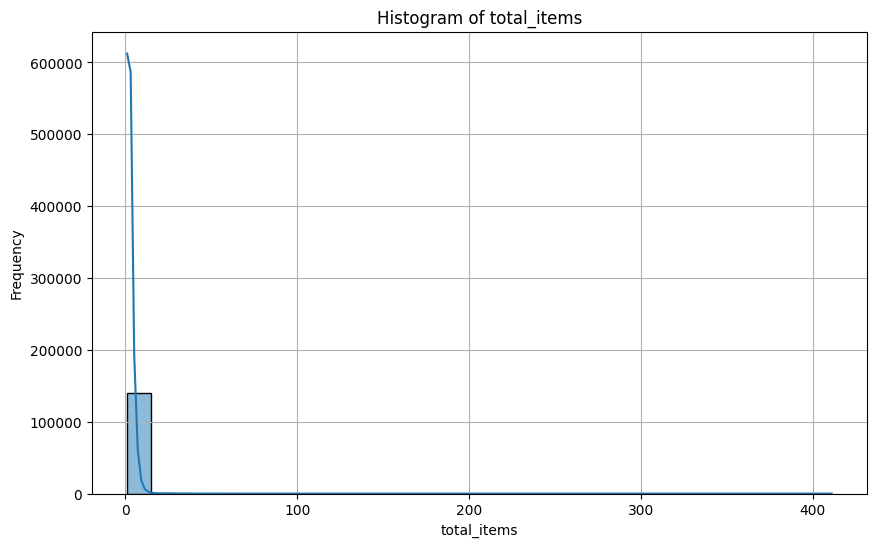

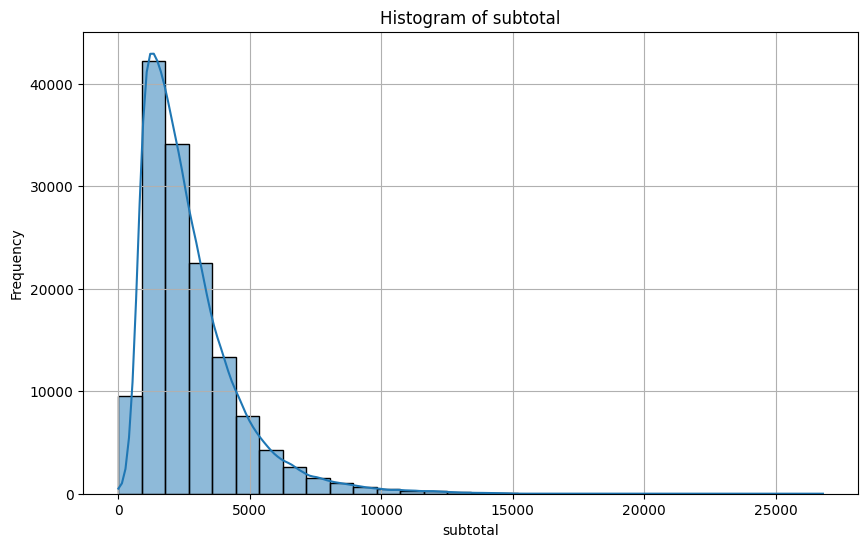

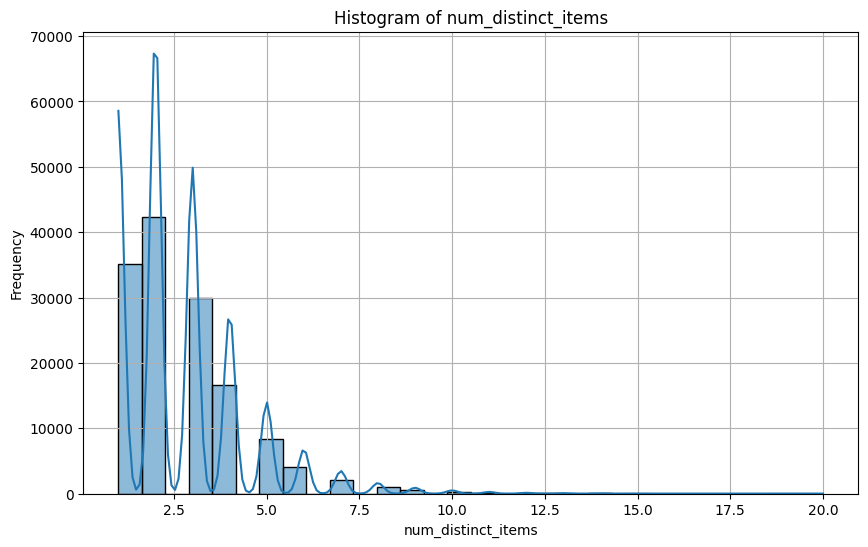

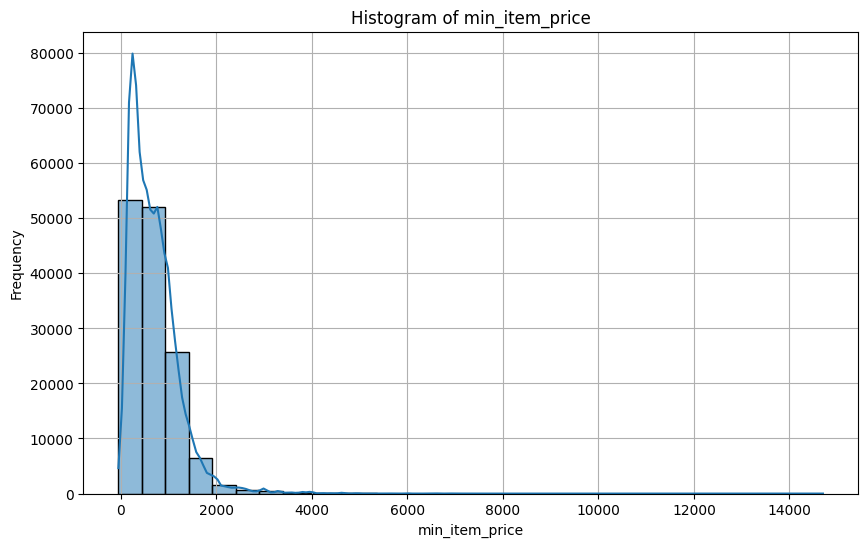

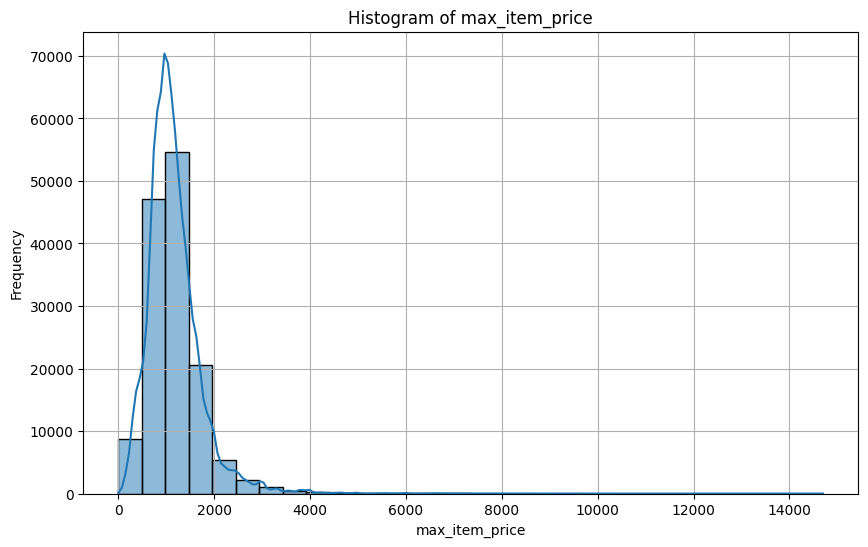

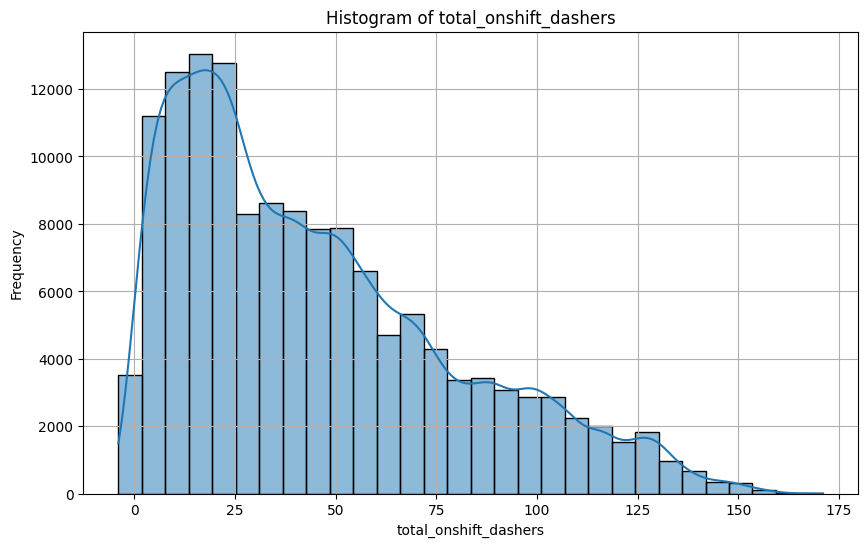

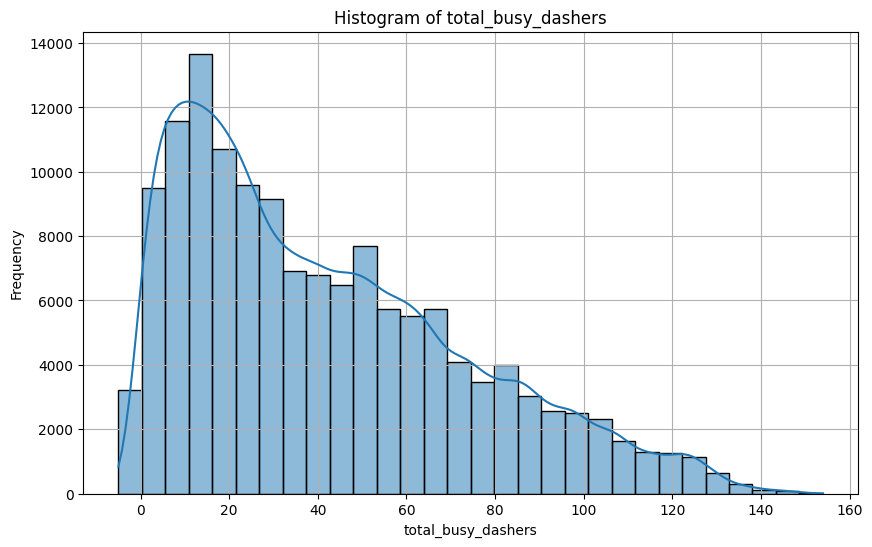

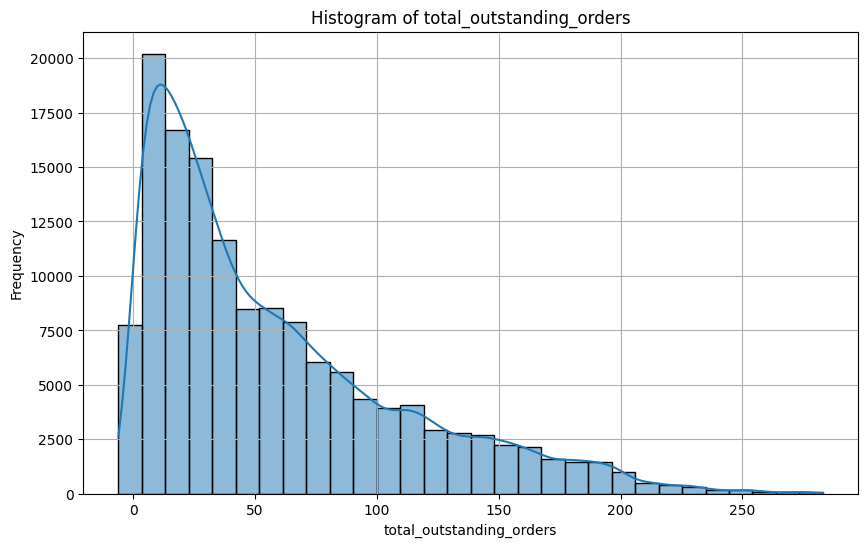

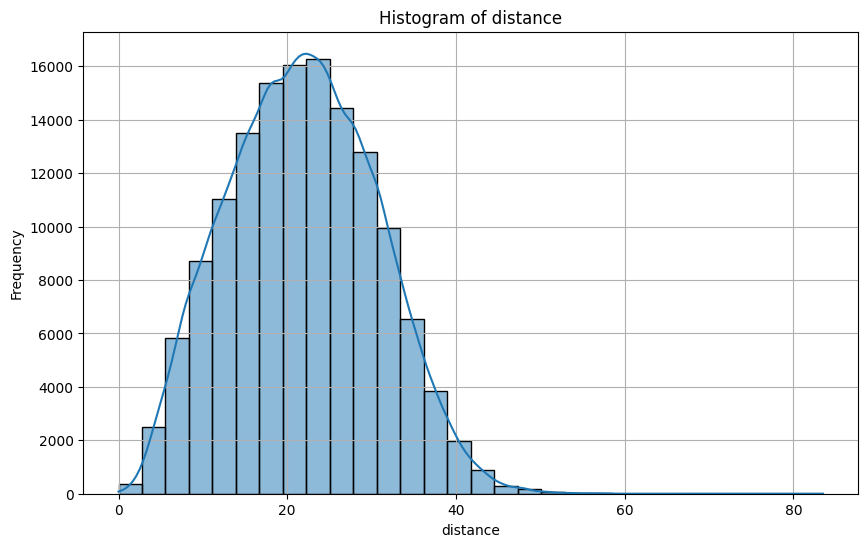

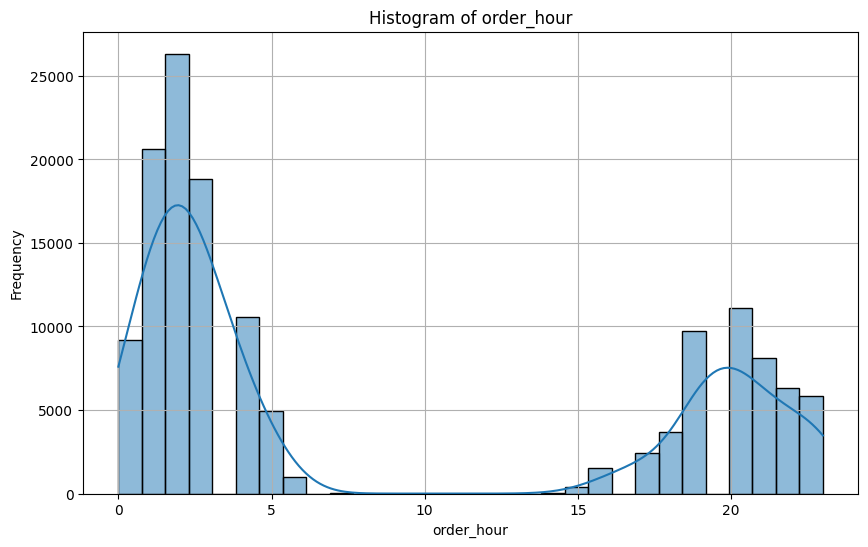

In [28]:
# Plot distributions for all numerical columns
for i in num_cols:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=X_train, x=i, bins=30, kde=True)
    plt.title(f'Histogram of {i}')  # Adding a title for each histogram
    plt.xlabel(i)  # x-axis label
    plt.ylabel('Frequency')  # y-axis label
    plt.grid(True)  # Adding a grid for better readability
    plt.show()


##### **3.1.2** <font color = red>[2 marks]</font> <br>
Check the distribution of categorical features

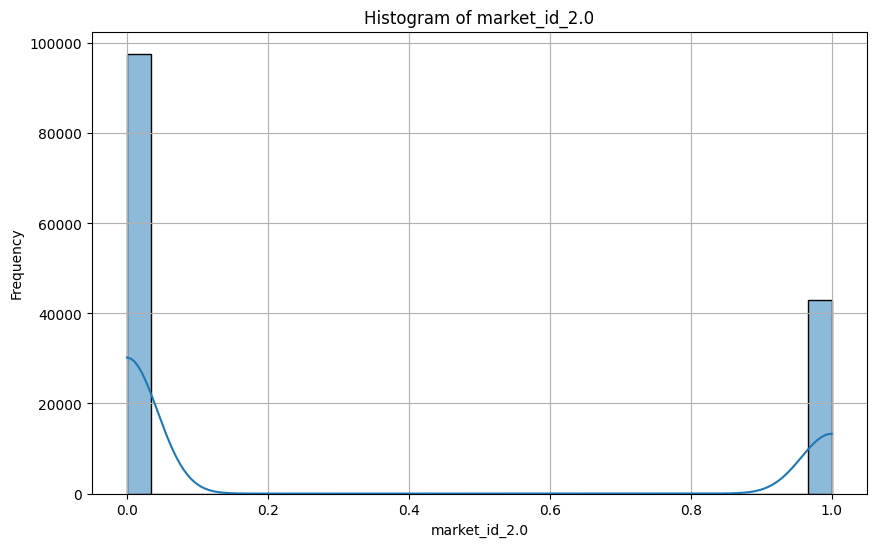

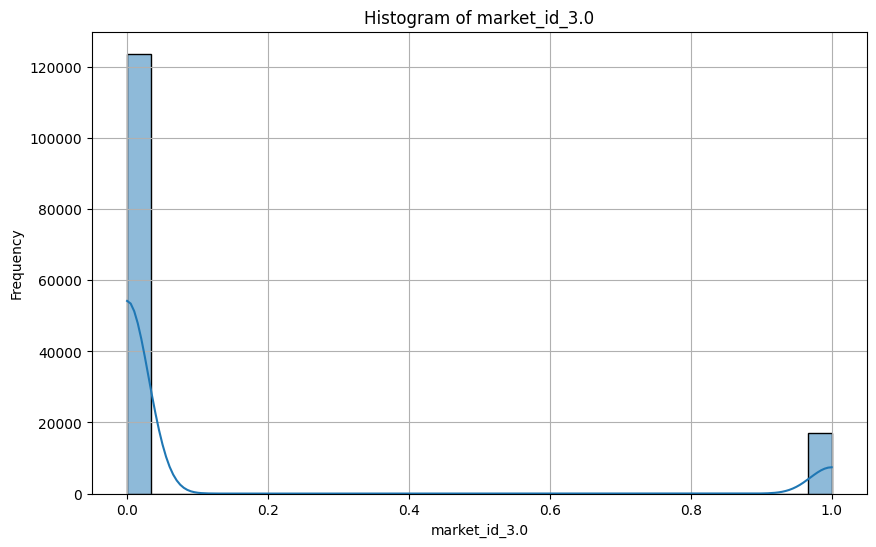

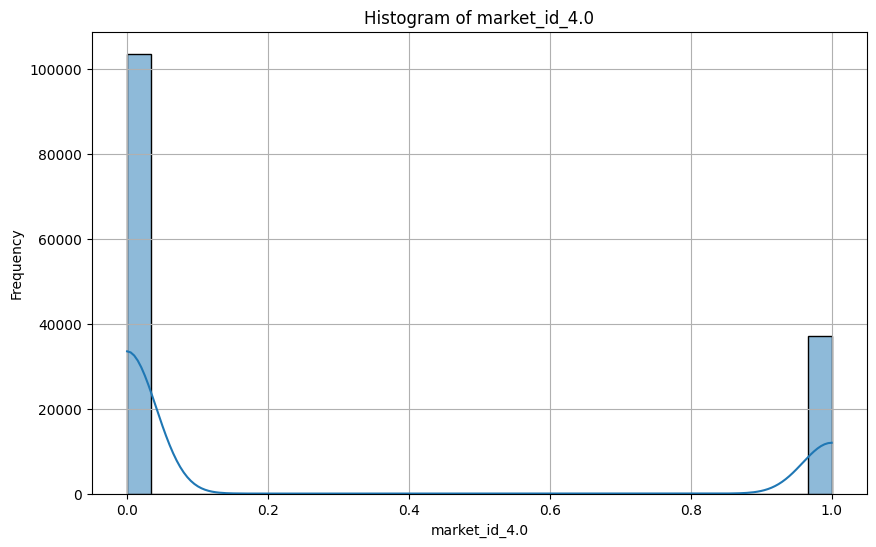

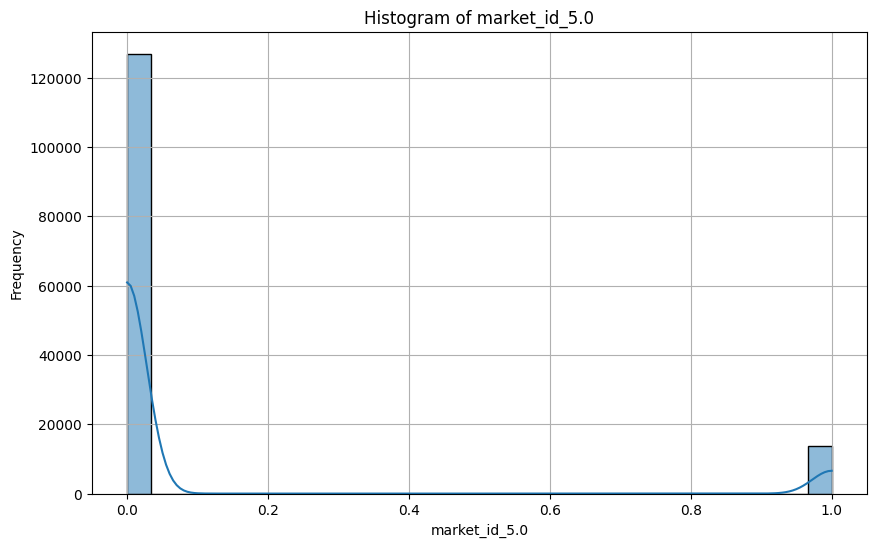

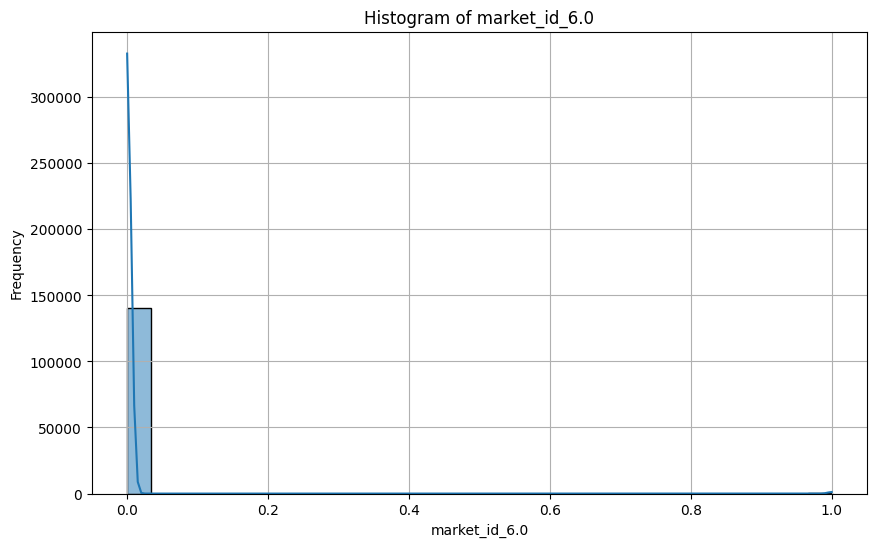

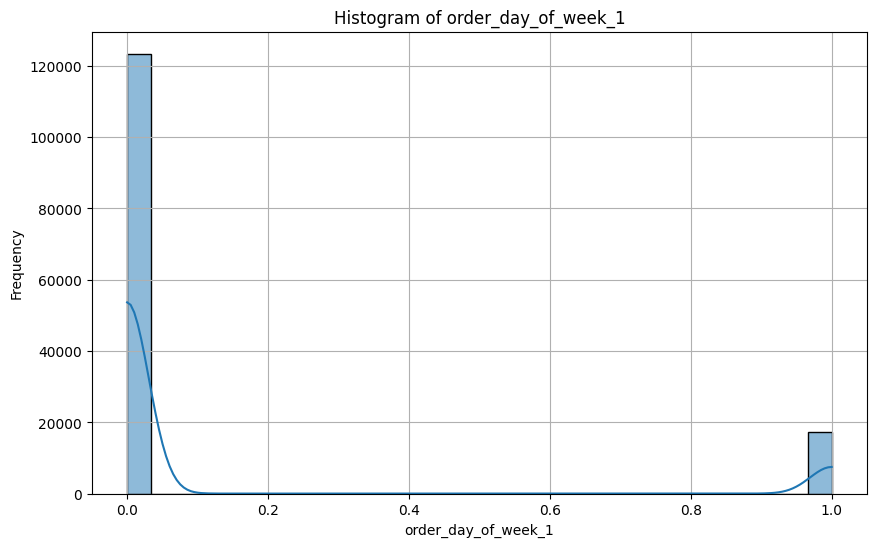

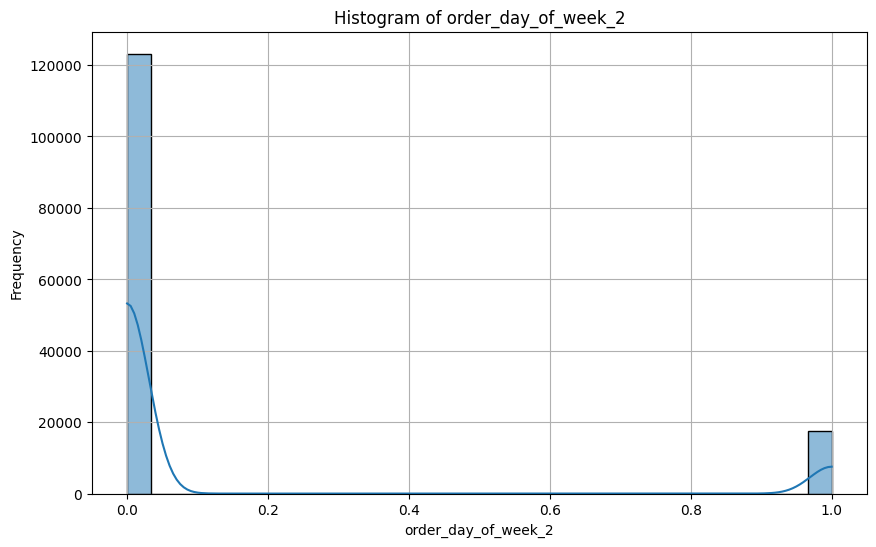

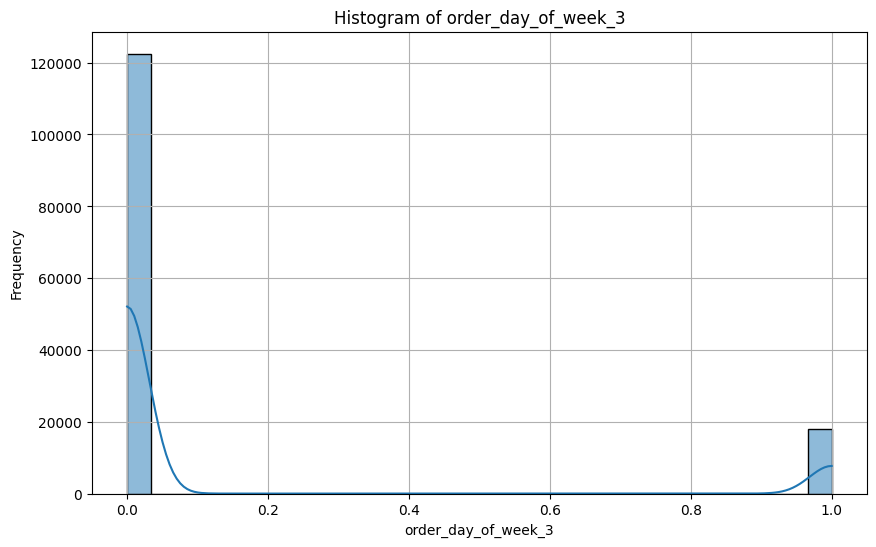

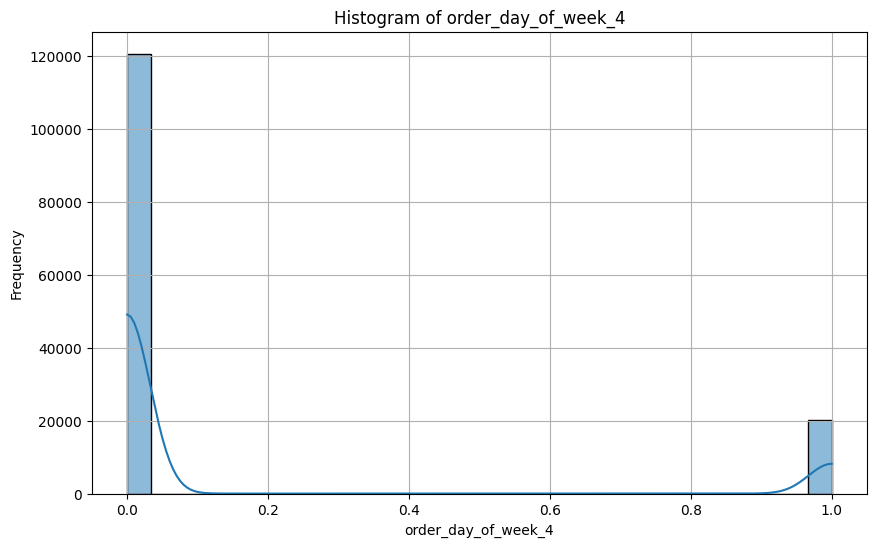

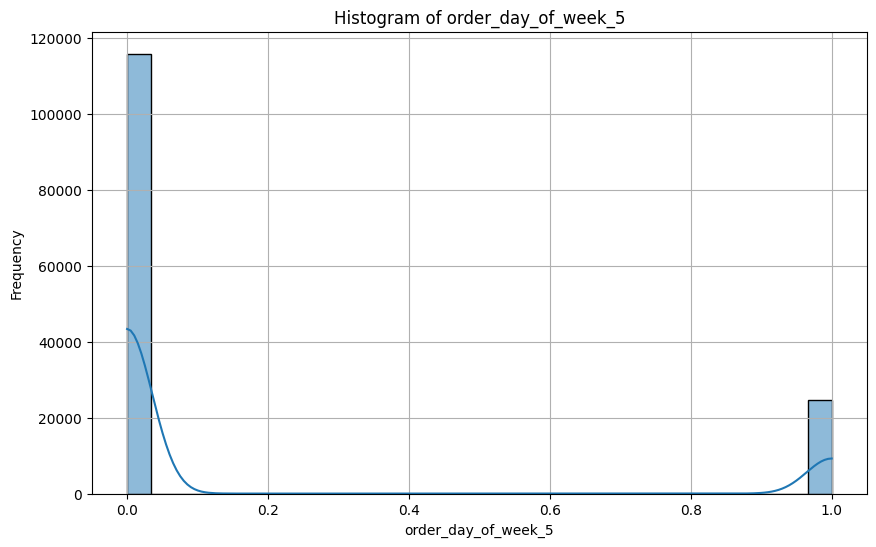

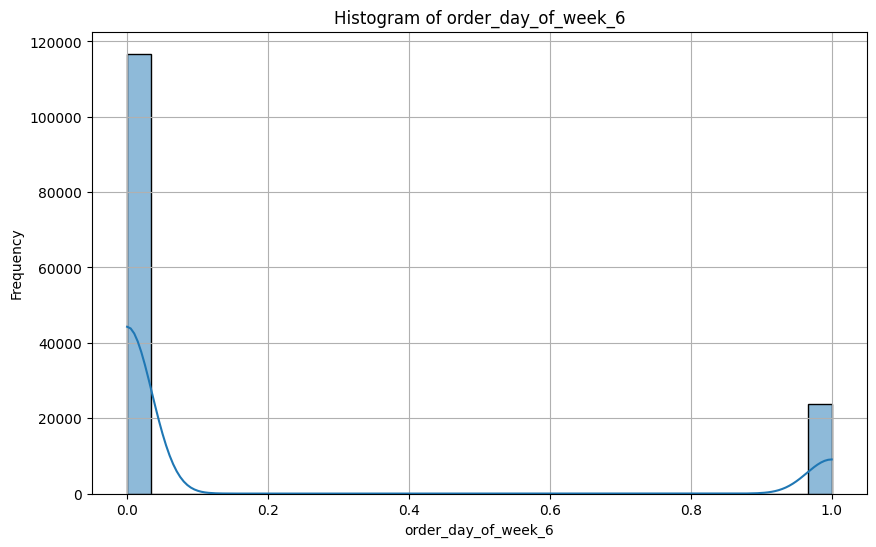

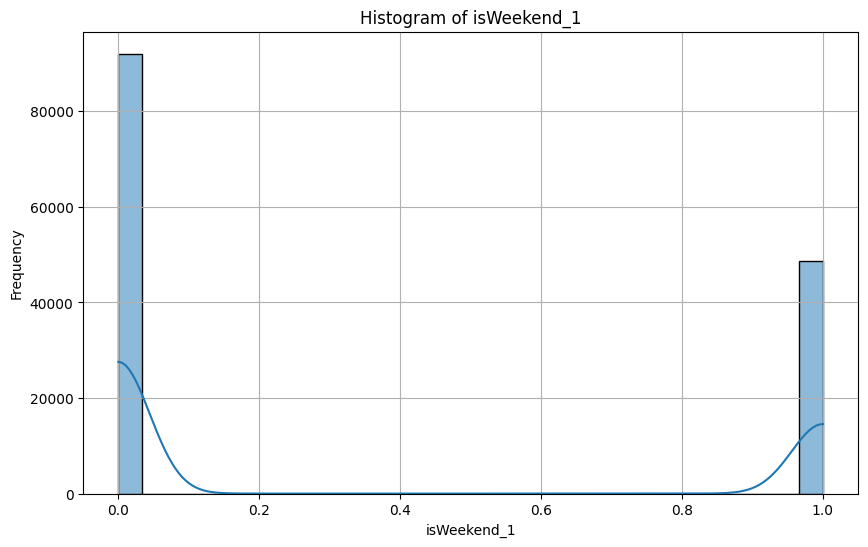

In [29]:
# Distribution of categorical columns
for i in cat_cols:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=X_train, x=i, bins=30, kde=True)
    plt.title(f'Histogram of {i}')  # Adding a title for each histogram
    plt.xlabel(i)  # x-axis label
    plt.ylabel('Frequency')  # y-axis label
    plt.grid(True)  # Adding a grid for better readability
    plt.show()




##### **3.1.3** <font color = red>[2 mark]</font> <br>
Visualise the distribution of the target variable to understand its spread and any skewness

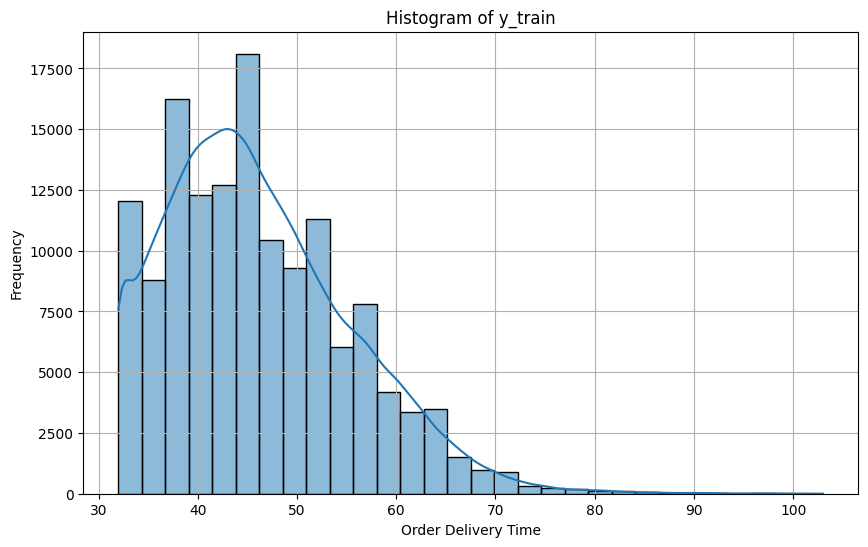

In [30]:
# Distribution of time_taken
plt.figure(figsize=(10, 6))
sns.histplot(y_train, bins=30, kde=True)
plt.title('Histogram of y_train')  # Title for the histogram
plt.xlabel('Order Delivery Time')  # Label for the x-axis
plt.ylabel('Frequency')  # Label for the y-axis
plt.grid(True)
plt.show()


#### **3.2 Relationships Between Features** <font color = red>[3 marks]</font> <br>

##### **3.2.1** <font color = red>[3 marks]</font> <br>
Scatter plots for important numerical and categorical features to observe how they relate to `time_taken`

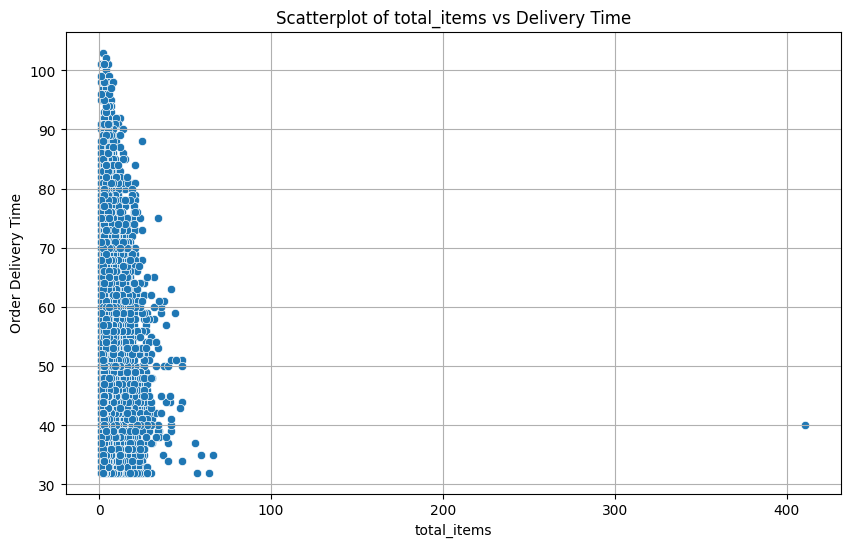

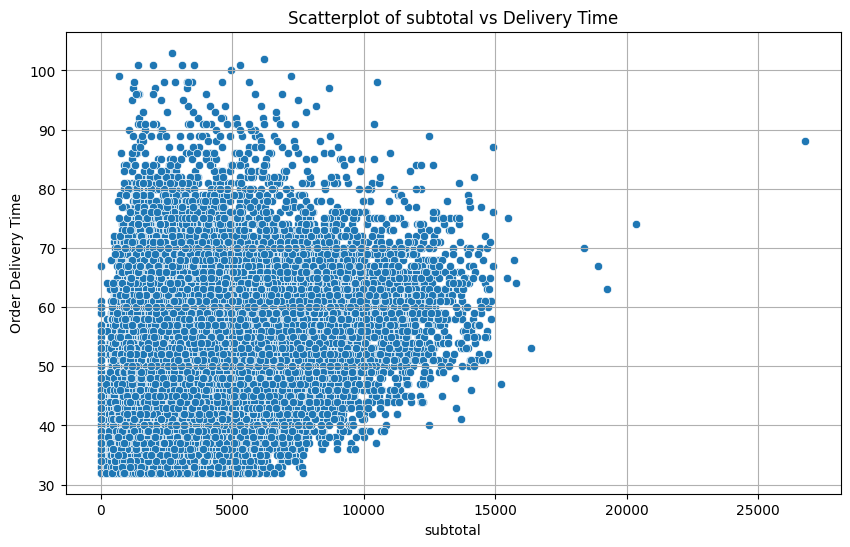

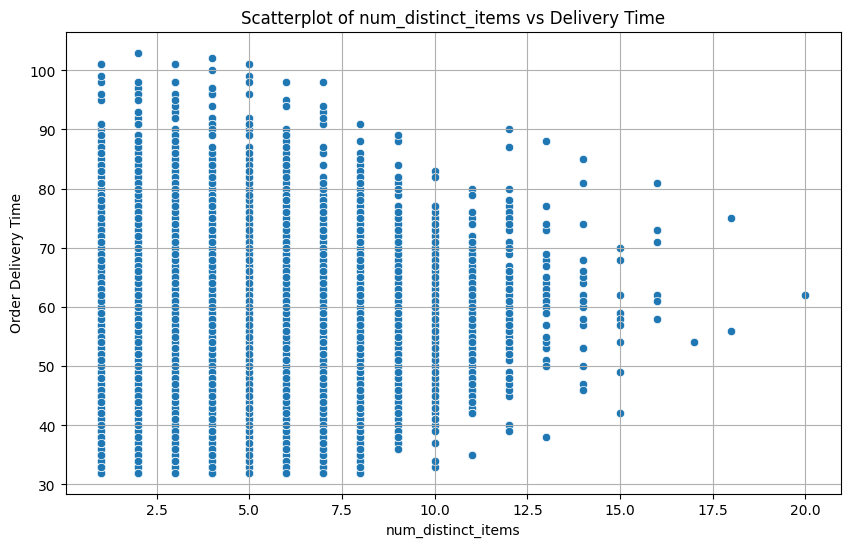

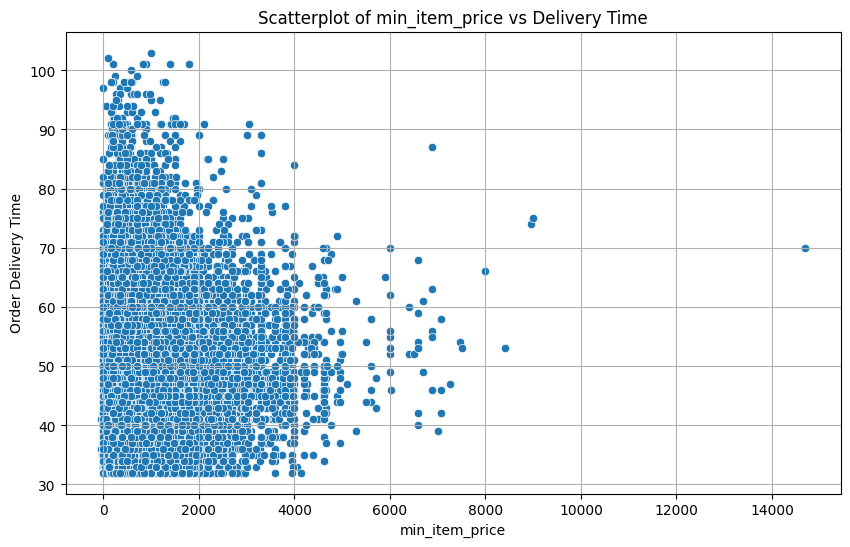

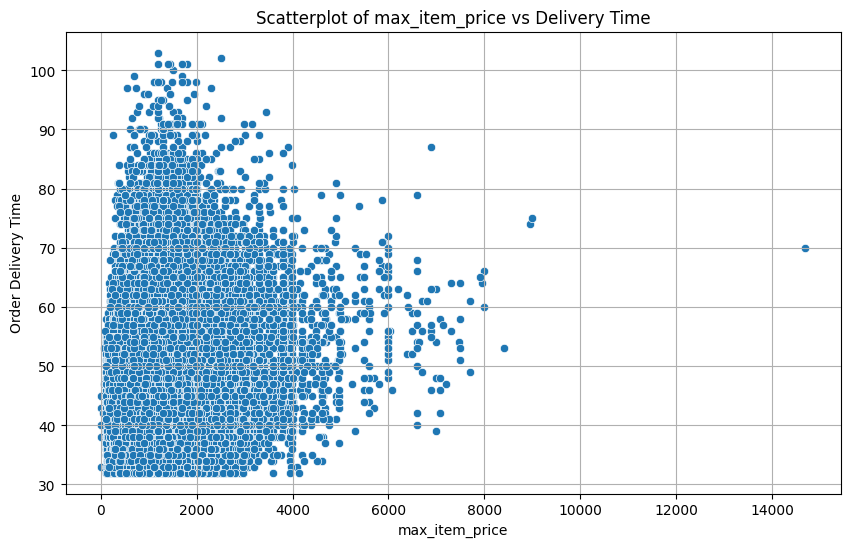

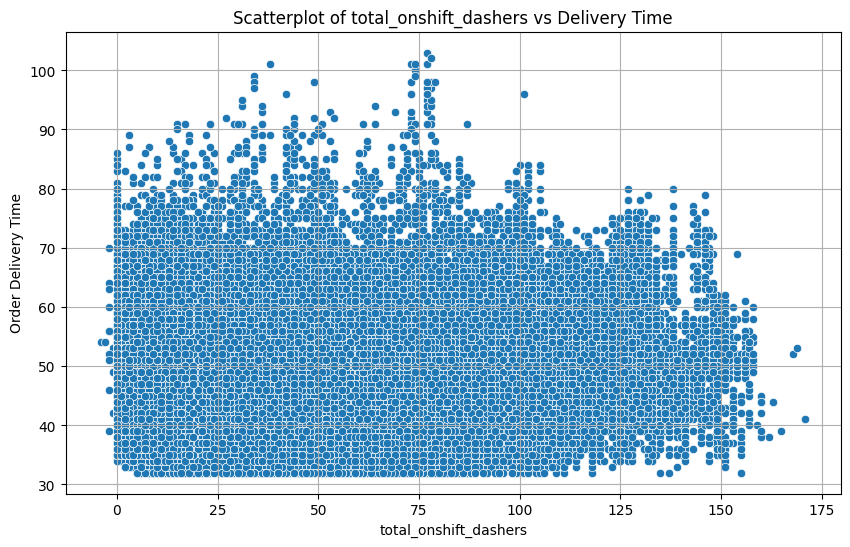

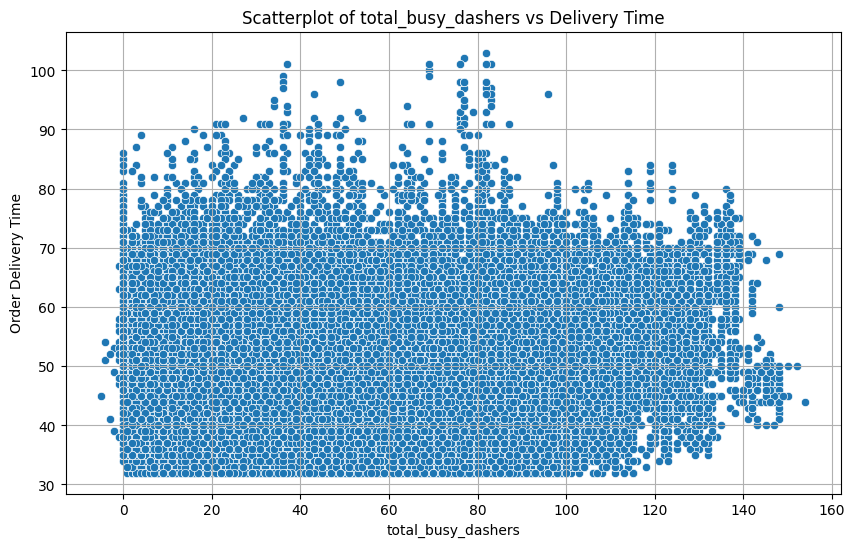

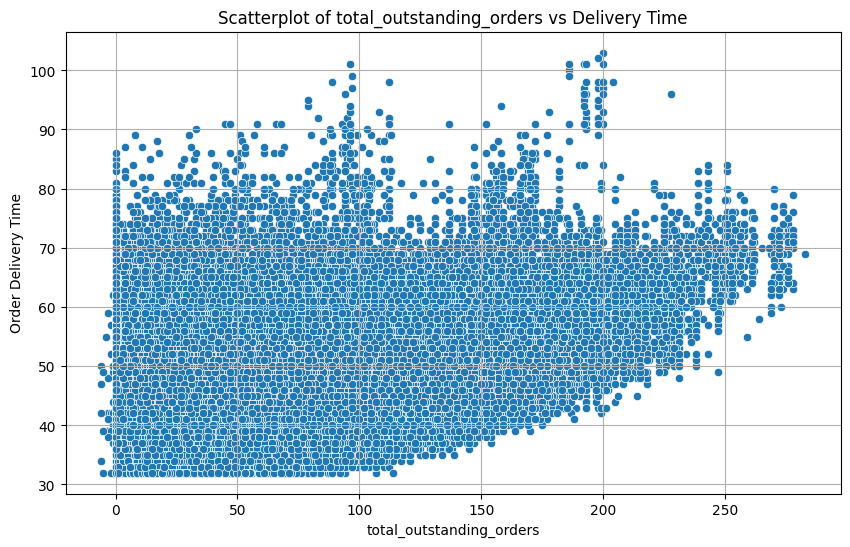

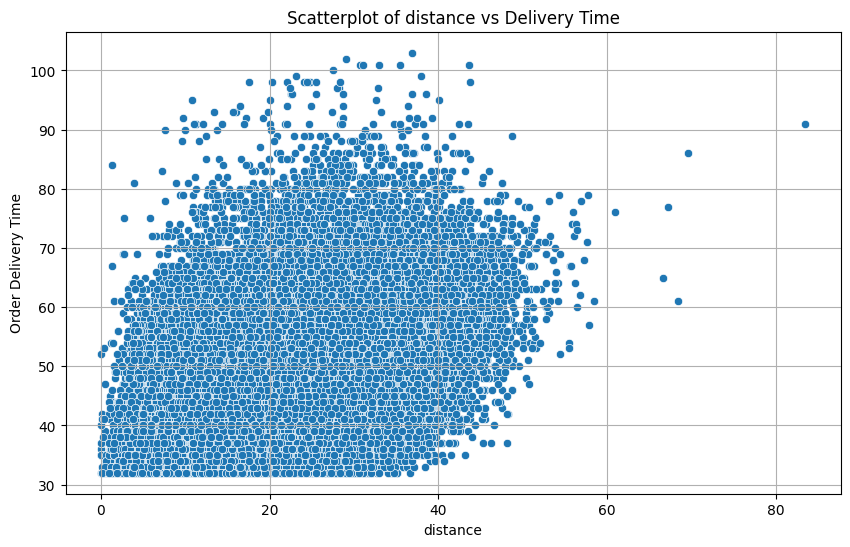

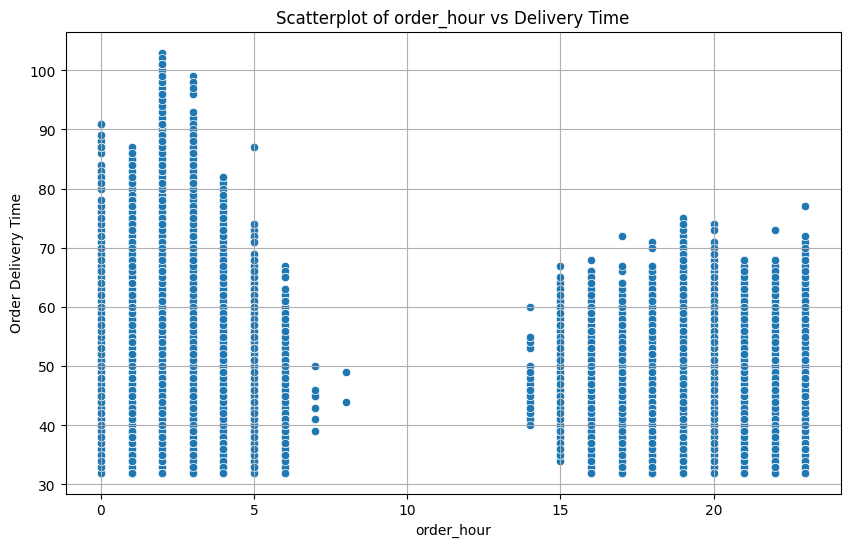

In [31]:
# Scatter plot to visualise the relationship between time_taken and other features
for i in num_cols:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=X_train[i], y=y_train)
    plt.title(f'Scatterplot of {i} vs Delivery Time')  # Adding a descriptive title
    plt.xlabel(i)  # Label x-axis with the feature name
    plt.ylabel('Order Delivery Time')  # Label y-axis
    plt.grid(True)
    plt.show()


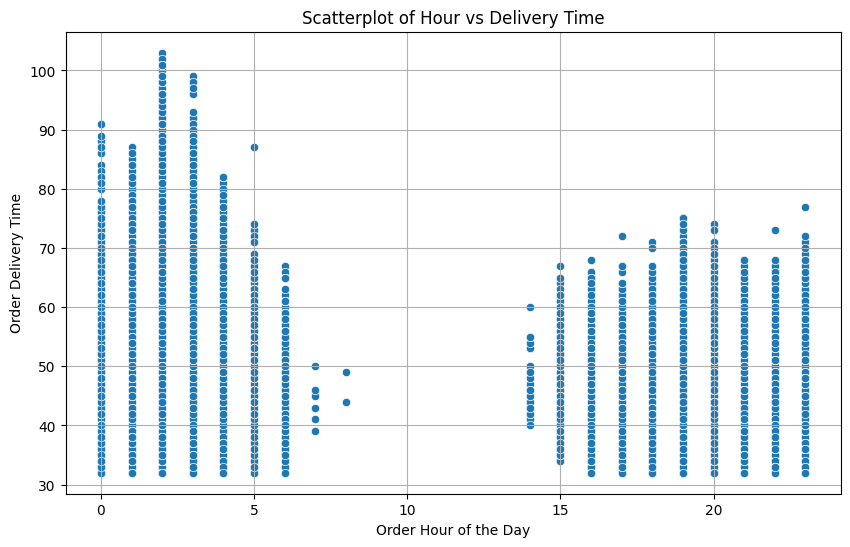

In [32]:
# Show the distribution of time_taken for different hours
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_train["order_hour"], y=y_train)
plt.title('Scatterplot of Hour vs Delivery Time')  # Title for the scatterplot
plt.xlabel('Order Hour of the Day')  # Label for the x-axis
plt.ylabel('Order Delivery Time')  # Label for the y-axis
plt.grid(True)
plt.show()


#### **3.3 Correlation Analysis** <font color = red>[5 marks]</font> <br>
Check correlations between numerical features to identify which variables are strongly related to `time_taken`

##### **3.3.1** <font color = red>[3 marks]</font> <br>
Plot a heatmap to display correlations

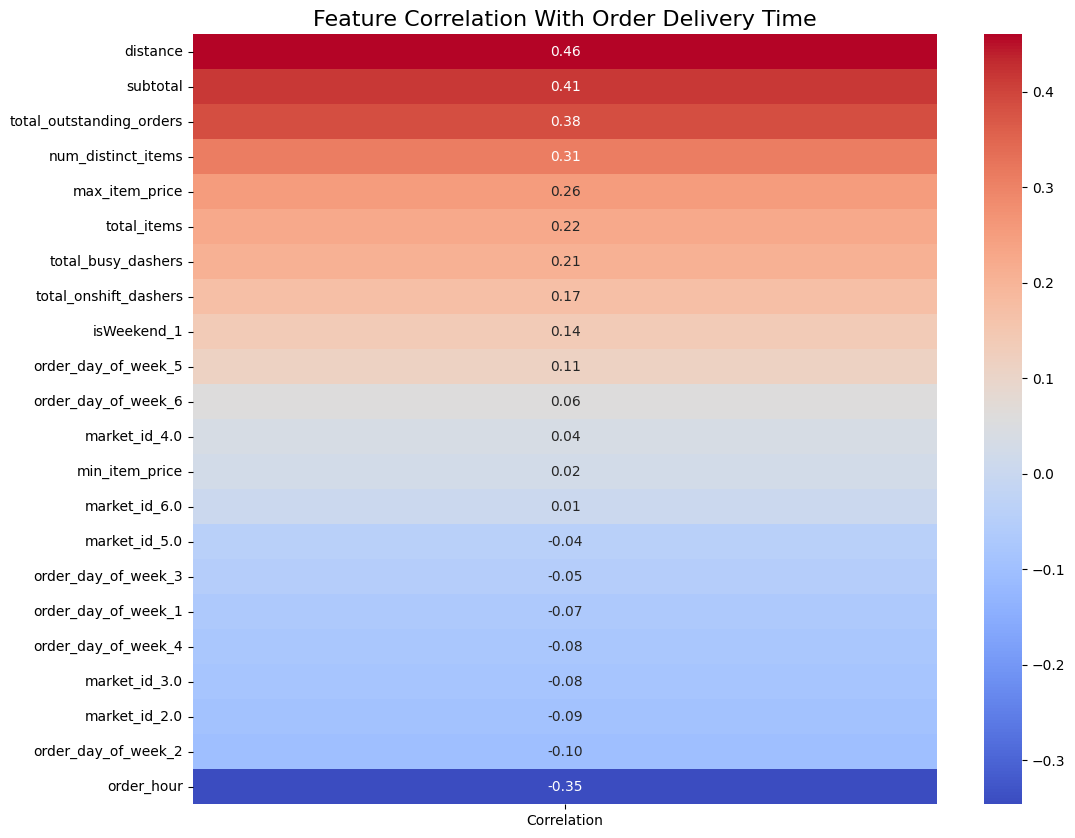

In [33]:
# Plot the heatmap of the correlation matrix
# Calculate the correlation of all columns with the target variable y
corr_all_cols = X.corrwith(y).sort_values(ascending=False)
corr_df = pd.DataFrame(corr_all_cols, columns=['Correlation'])
plt.figure(figsize=(12, 10))
sns.heatmap(corr_df, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Feature Correlation With Order Delivery Time", fontsize=16)
plt.show()


##### **3.3.2** <font color = red>[2 marks]</font> <br>
Drop the columns with weak correlations with the target variable

In [34]:
# Drop 3-5 weakly correlated columns from training dataset
X_train.drop(columns=['order_day_of_week_5','order_day_of_week_6','min_item_price','market_id_4.0','market_id_5.0'], inplace=True)

#--Apply this on X_test 
X_test.drop(columns=['order_day_of_week_5','order_day_of_week_6','min_item_price','market_id_4.0','market_id_5.0'], inplace=True)

X_train = X_train.reset_index(drop=True)


#### **3.4 Handling the Outliers** <font color = red>[5 marks]</font> <br>



##### **3.4.1** <font color = red>[2 marks]</font> <br>
Visualise potential outliers for the target variable and other numerical features using boxplots

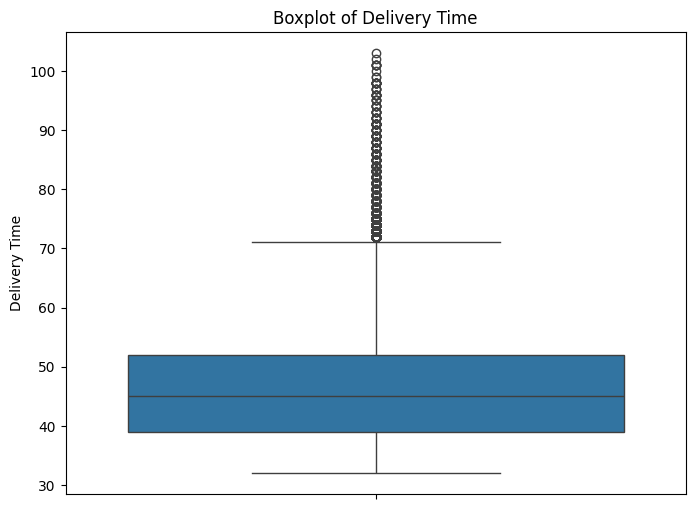

In [35]:
# Boxplot for time_taken
plt.figure(figsize=(8, 6))
sns.boxplot(y=y_train)
plt.title('Boxplot of Delivery Time')
plt.ylabel('Delivery Time')
plt.show()


In [36]:
num_cols_1= ['total_items', 'subtotal', 'num_distinct_items', 'max_item_price', 
           'total_onshift_dashers', 'total_busy_dashers','total_outstanding_orders', 'distance', 'order_hour']

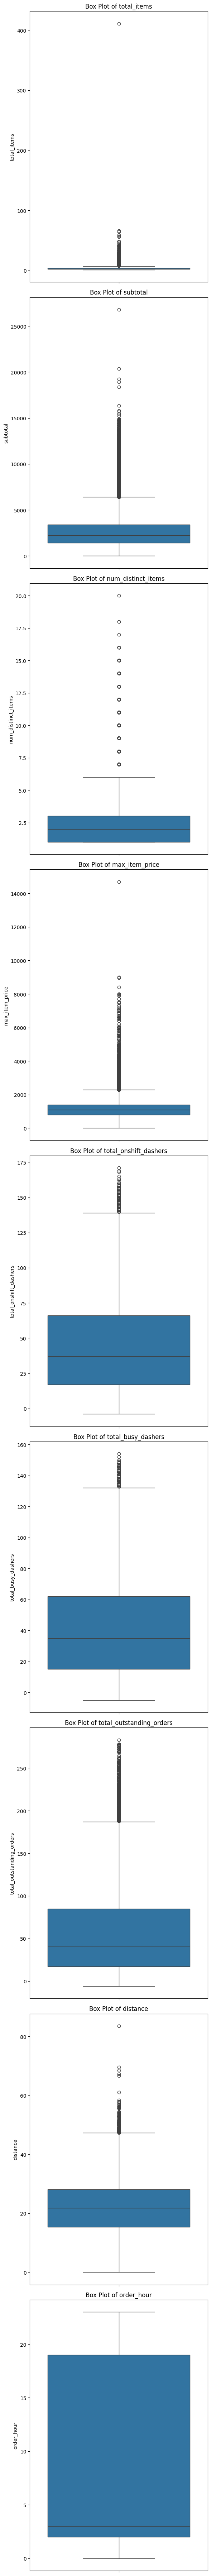

In [37]:
# Create subplots with a row for each numeric column in num_cols_1
fig, axes = plt.subplots(nrows=len(num_cols_1), figsize=(6, 8 * len(num_cols_1)))
# Plot boxplot for each numeric column on its respective subplot
for i, col in enumerate(num_cols_1):
    sns.boxplot(y=X_train[col], ax=axes[i])
    axes[i].set_title(f"Box Plot of {col}")
    axes[i].set_ylabel(col)
plt.tight_layout()
plt.show()

##### **3.4.2** <font color = red>[3 marks]</font> <br>
Handle outliers present in all columns

In [38]:
# Handle outliers
#1 . Handling negative values for the below , with abs function, as the delivery partners cannot be negative
X_train[['total_onshift_dashers','total_busy_dashers','total_outstanding_orders']] = X_train[[ 'total_onshift_dashers','total_busy_dashers','total_outstanding_orders']].apply(np.abs)

#2 .Though subtotal and distance have zeors or outliers, imputing / removing them is resulting in a drastic drop in model performance , hence I had to revert those changes.
#Resetting index after modying the above values
X_train = X_train.reset_index(drop=True)
X_train.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140621 entries, 0 to 140620
Data columns (total 17 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   total_items               140621 non-null  int64  
 1   subtotal                  140621 non-null  int64  
 2   num_distinct_items        140621 non-null  int64  
 3   max_item_price            140621 non-null  int64  
 4   total_onshift_dashers     140621 non-null  float64
 5   total_busy_dashers        140621 non-null  float64
 6   total_outstanding_orders  140621 non-null  float64
 7   distance                  140621 non-null  float64
 8   order_hour                140621 non-null  int32  
 9   market_id_2.0             140621 non-null  int64  
 10  market_id_3.0             140621 non-null  int64  
 11  market_id_6.0             140621 non-null  int64  
 12  order_day_of_week_1       140621 non-null  int64  
 13  order_day_of_week_2       140621 non-null  i

## **4. Exploratory Data Analysis on Validation Data** <font color = red>[optional]</font> <br>
Optionally, perform EDA on test data to see if the distribution match with the training data

In [39]:
# Define numerical and categorical columns for easy EDA and data manipulation
num_cols_1= ['total_items', 'subtotal', 'num_distinct_items', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance', 'order_hour']

cat_cols_1 = ['market_id_2.0', 'market_id_3.0', 'market_id_6.0', 'order_day_of_week_1', 'order_day_of_week_2', 'order_day_of_week_3', 'order_day_of_week_4', 'isWeekend_1']

#### **4.1 Feature Distributions**


##### **4.1.1**
Plot distributions for numerical columns in the validation set to understand their spread and any skewness

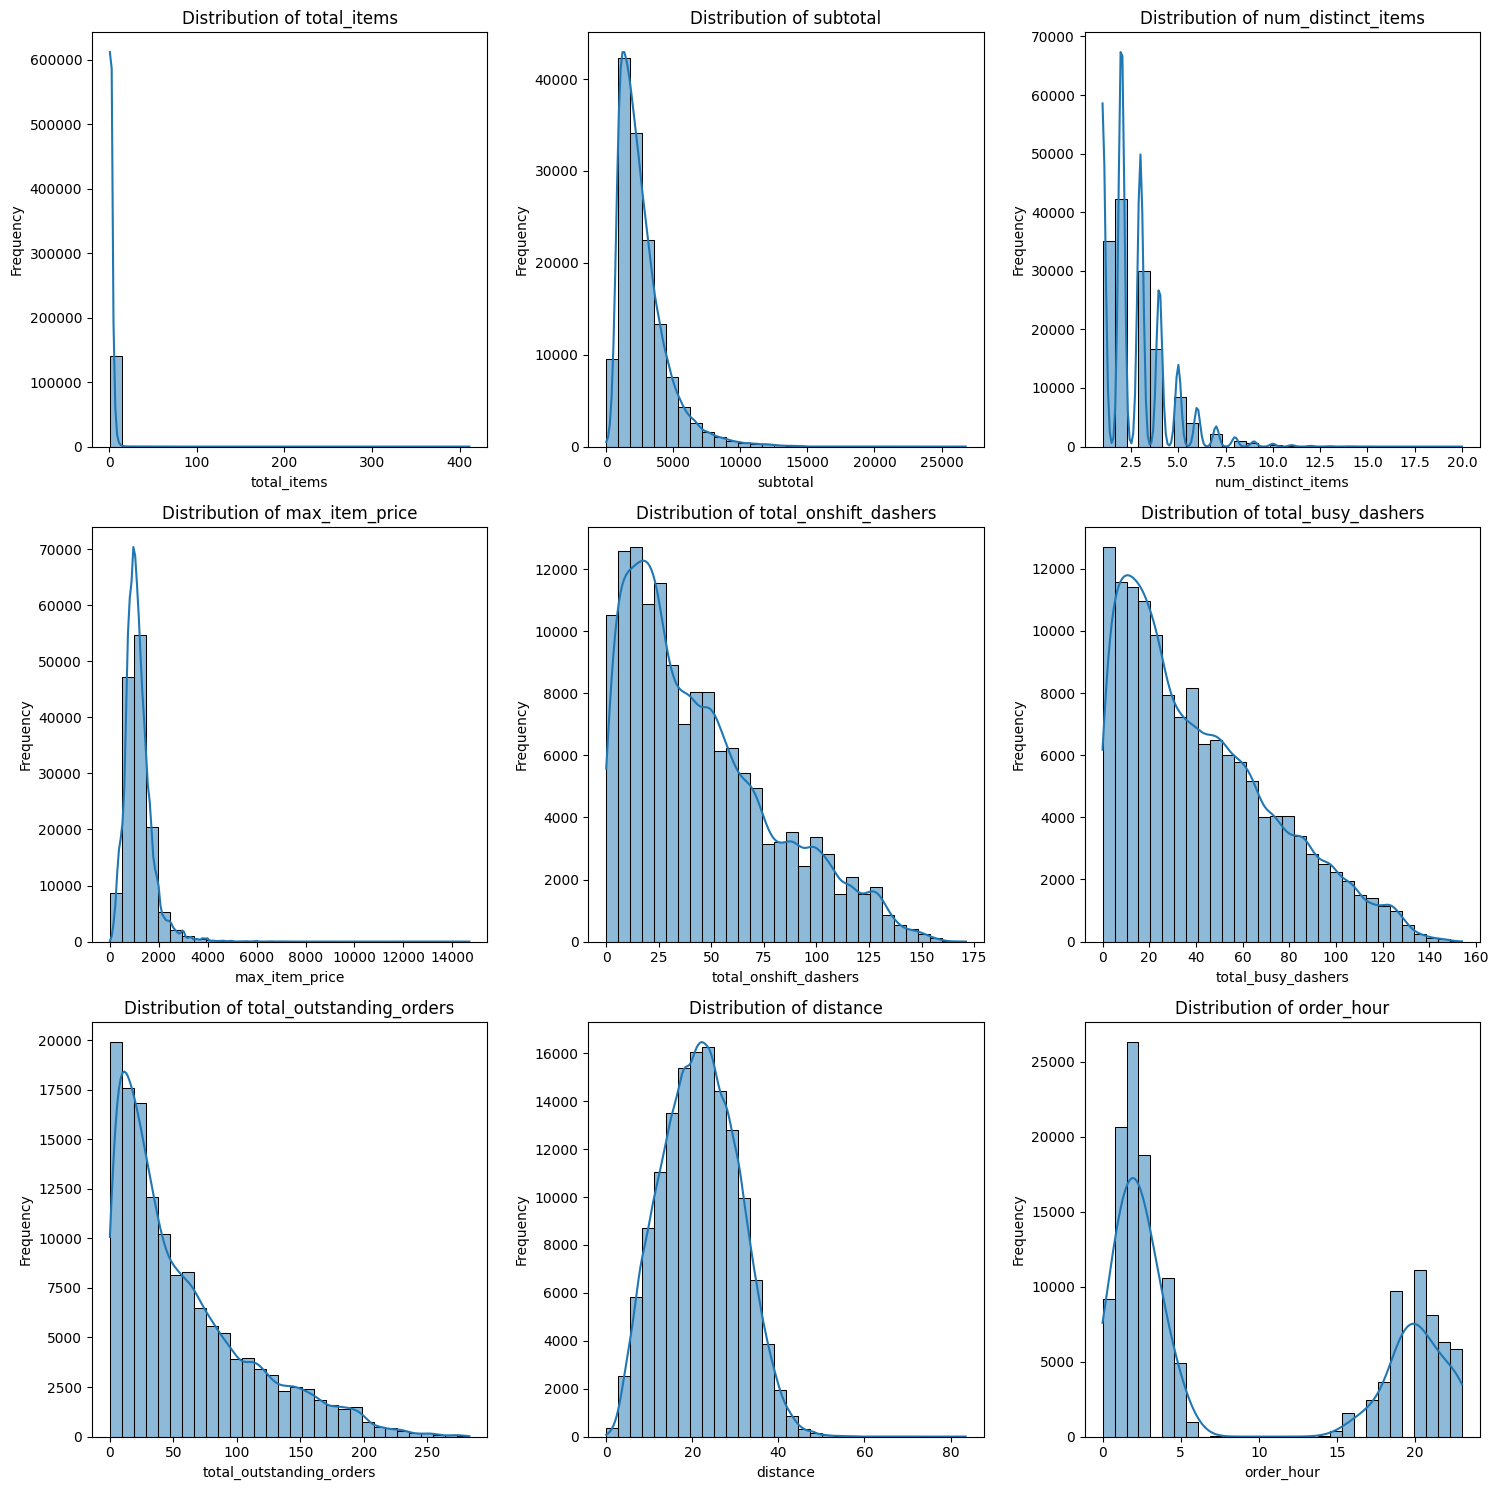

In [40]:
# Plot distributions for all numerical columns
n_cols = 3  # Number of columns in the subplot grid
n_rows = (len(num_cols_1) + n_cols - 1) // n_cols  # Calculating number of rows needed
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 5 * n_rows))
# Flattening the axes array for easy iteration
axes = axes.flatten()
for i, col in enumerate(num_cols_1):
    sns.histplot(X_train[col], ax=axes[i], bins=30, kde=True)  # Adding KDE for better visualization
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')
# Hiding any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)
plt.tight_layout()  # Adjusting layout to prevent overlap
plt.show()


##### **4.1.2**
Check the distribution of categorical features

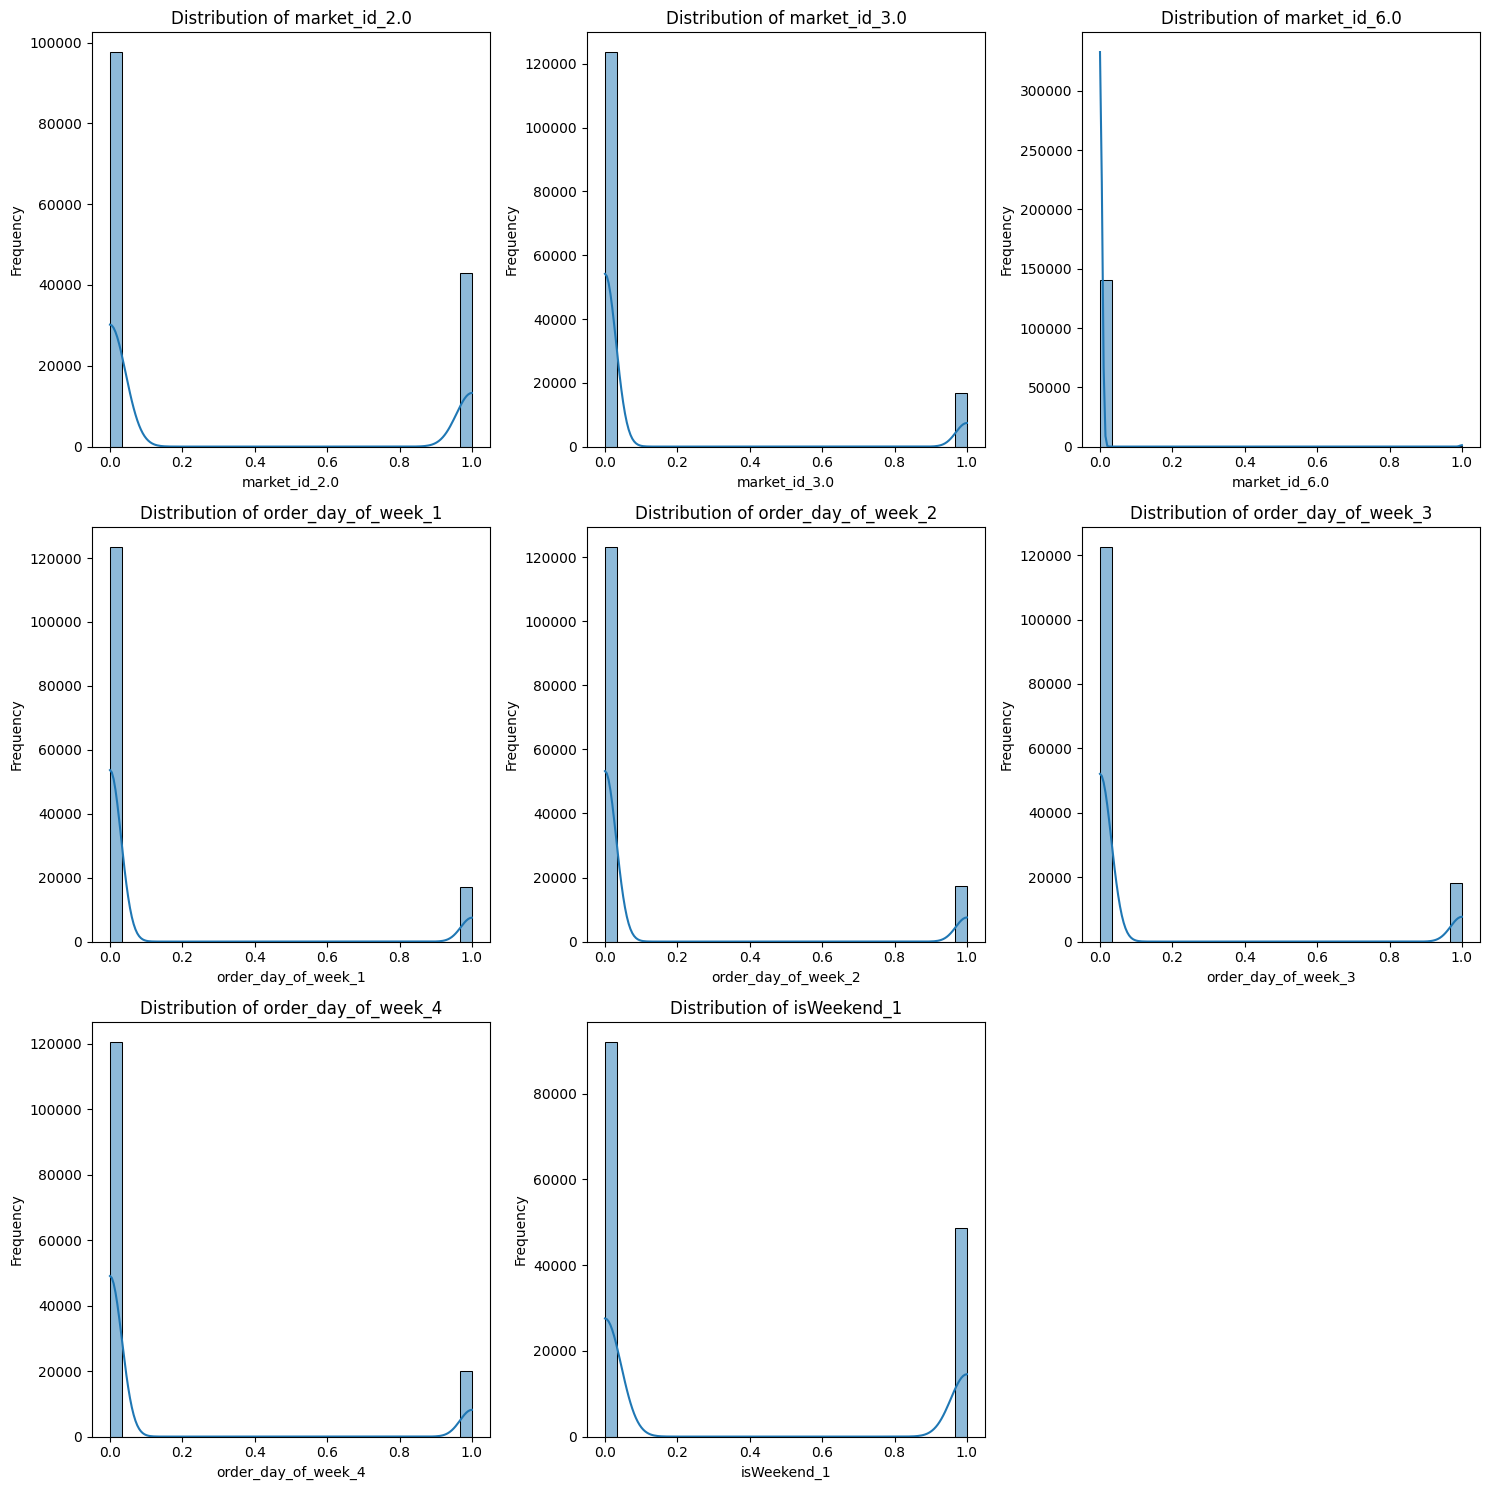

In [41]:
# Distribution of categorical columns
n_cols = 3  # Number of columns in the subplot grid
n_rows = (len(cat_cols_1) + n_cols - 1) // n_cols  # Calculating number of rows needed
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 5 * n_rows))
# Flattening the axes array for easy iteration
axes = axes.flatten()
for i, col in enumerate(cat_cols_1):
    sns.histplot(X_train[col], ax=axes[i], bins=30, kde=True)  # Adding KDE for better visualization
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')
# Hiding any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)
plt.tight_layout()  # Adjusting layout to prevent overlap
plt.show()


##### **4.1.3**
Visualise the distribution of the target variable to understand its spread and any skewness

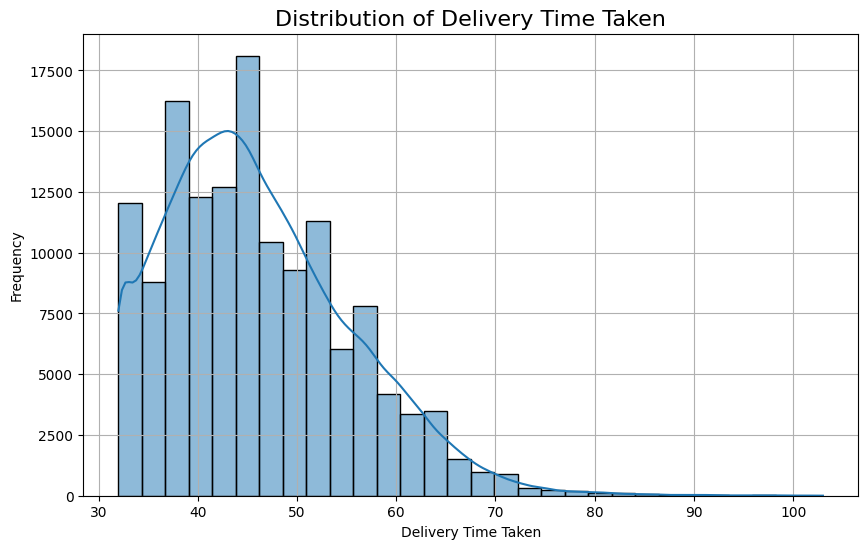

In [42]:
# Distribution of time_taken
plt.figure(figsize=(10, 6))
sns.histplot(y_train, bins=30, kde=True)
plt.title('Distribution of Delivery Time Taken', fontsize=16)
plt.xlabel('Delivery Time Taken')
plt.ylabel('Frequency')
plt.grid(True) 
plt.show()


#### **4.2 Relationships Between Features**
Scatter plots for numerical features to observe how they relate to each other, especially to `time_taken`

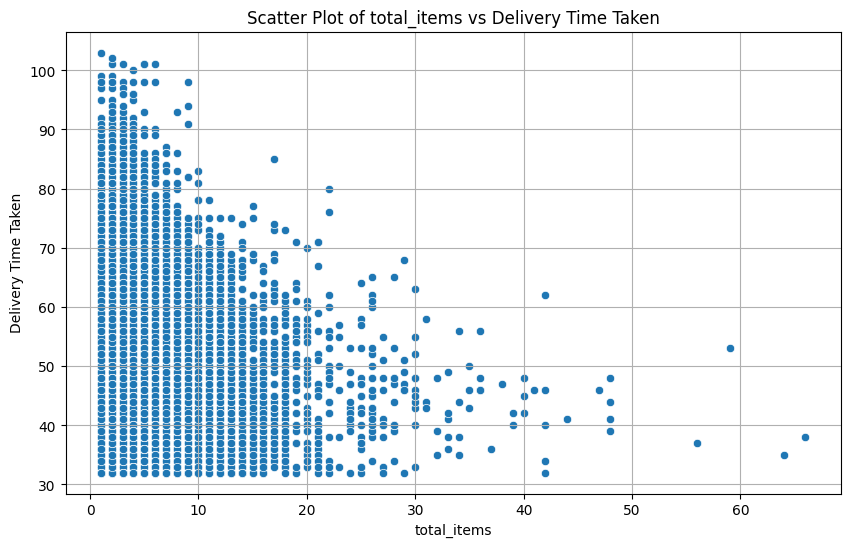

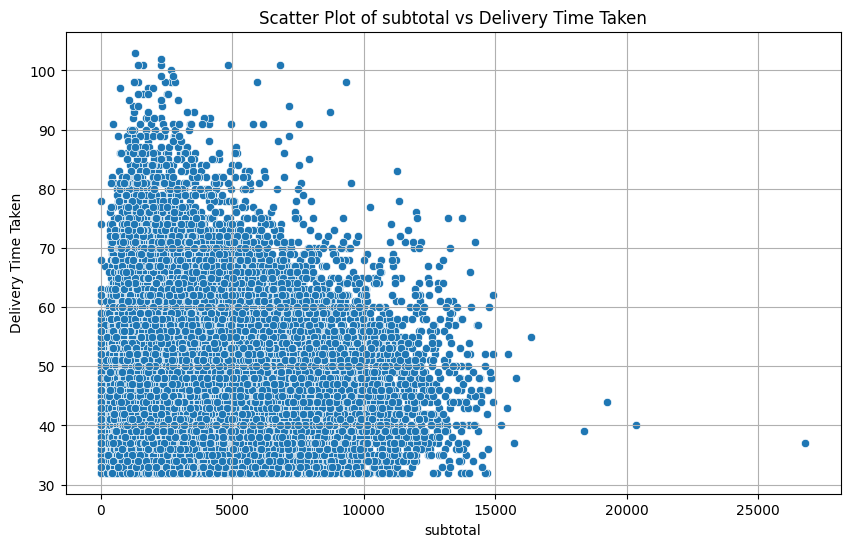

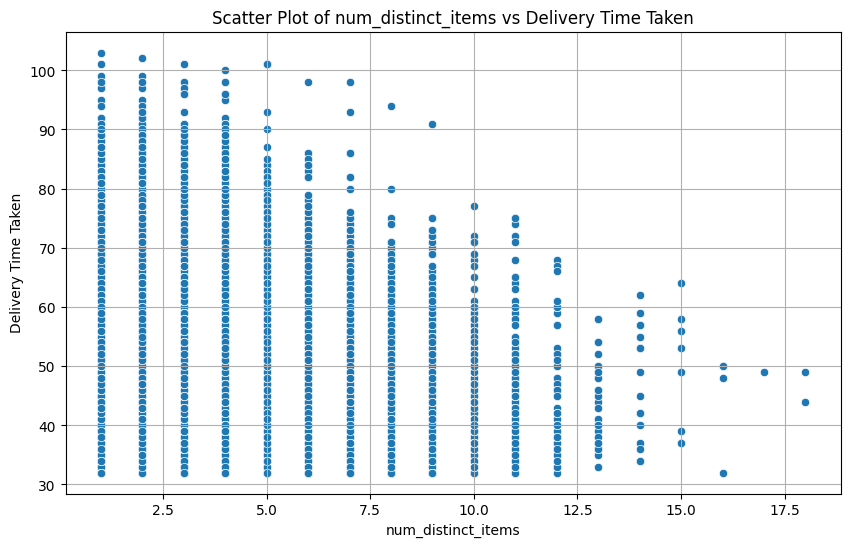

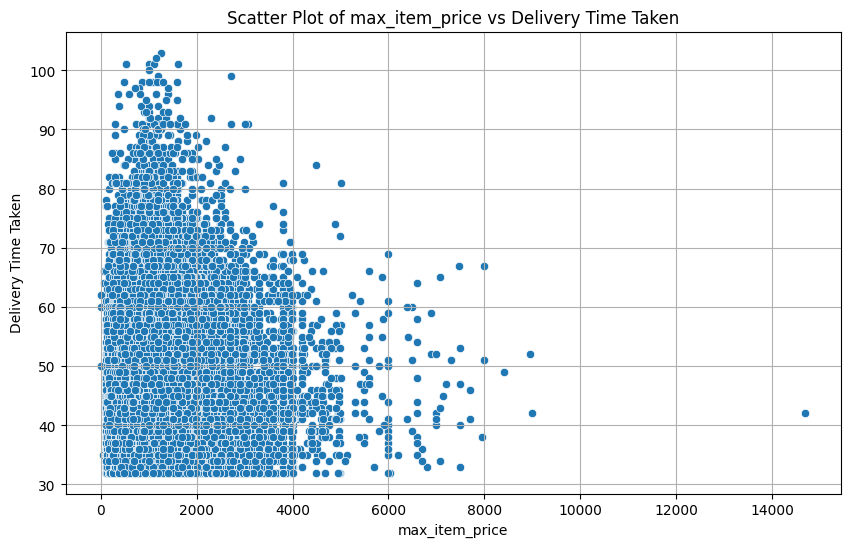

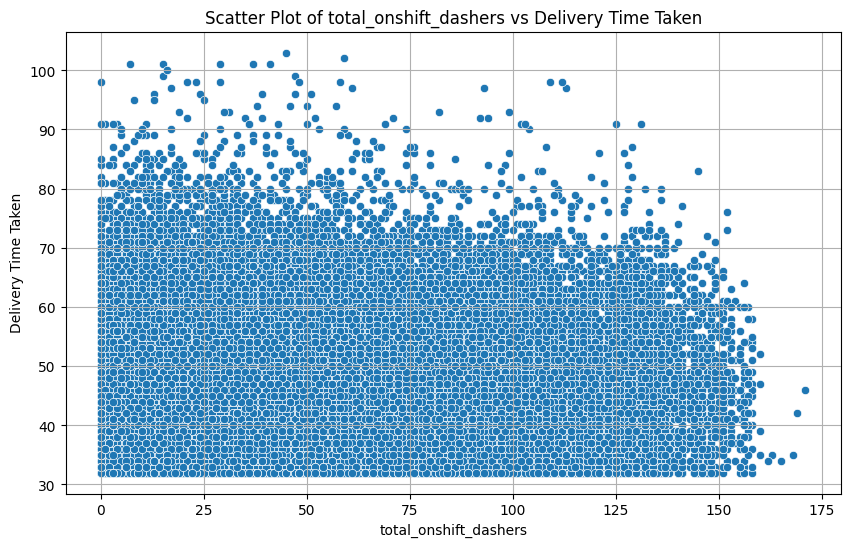

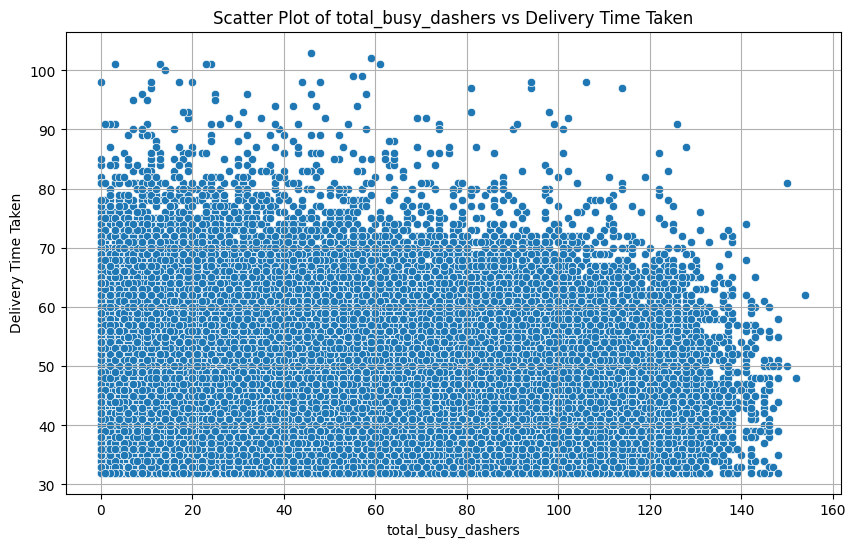

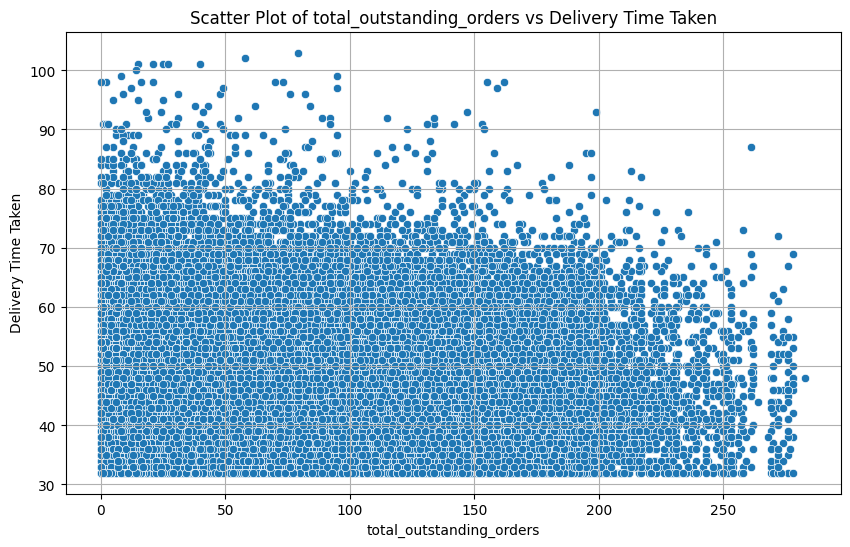

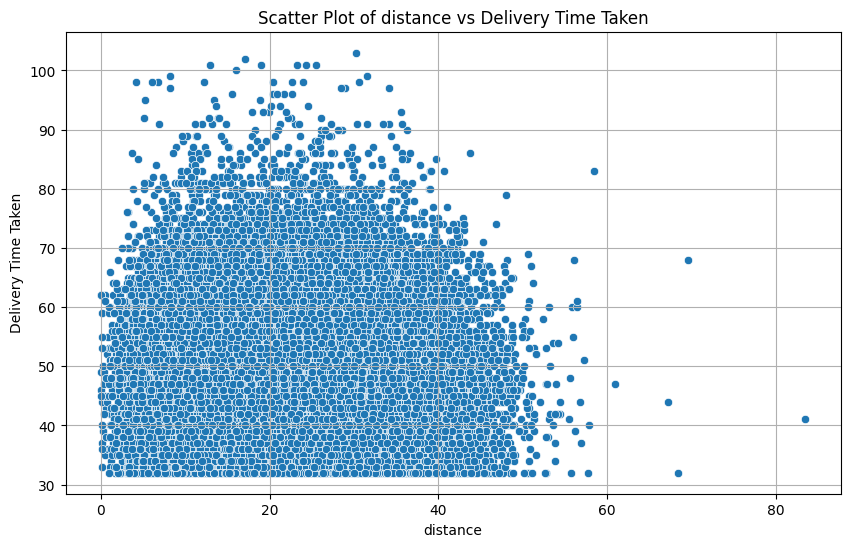

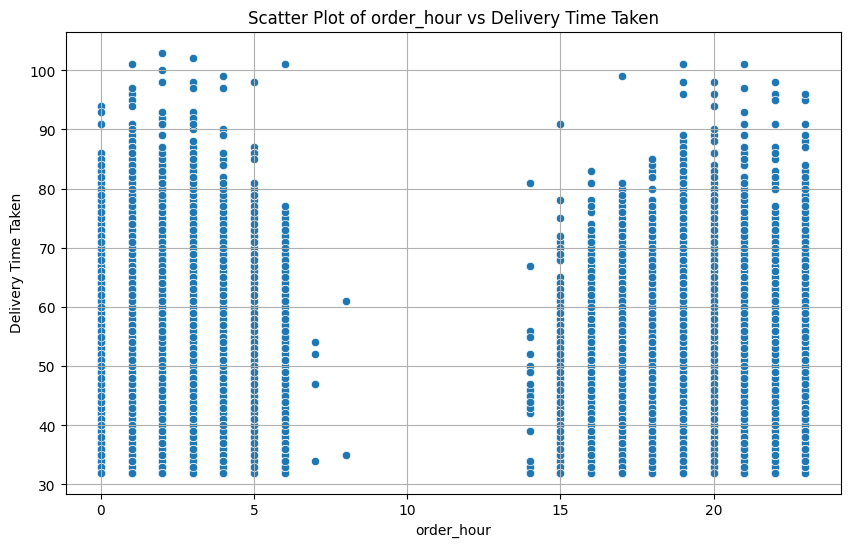

In [43]:
# Scatter plot to visualise the relationship between time_taken and other features
for col in num_cols_1:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=X_train[col], y=y_train)
    plt.title(f'Scatter Plot of {col} vs Delivery Time Taken')
    plt.xlabel(col)
    plt.ylabel('Delivery Time Taken')
    plt.grid(True)
    plt.show()


#### **4.3** Drop the columns with weak correlations with the target variable

In [ ]:
# Drop the weakly correlated columns from training dataset



## **5. Model Building** <font color = red>[15 marks]</font> <br>

#### **Import Necessary Libraries**

In [44]:
# Import libraries
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm # type: ignore


In [55]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(140621, 17)
(35156, 17)
(140621,)
(35156,)


#### **5.1 Feature Scaling** <font color = red>[3 marks]</font> <br>

In [45]:
# Apply scaling to the numerical columns
X_train_num_col_Scale = X_train
y_train_num_col_Scale = y_train
X_test_num_col_Scale = X_test
y_test_num_col_Scale = y_test

print(X_train_num_col_Scale.shape)
print(X_test_num_col_Scale.shape)
print(y_train_num_col_Scale.shape)
print(y_test_num_col_Scale.shape)


(140621, 17)
(35156, 17)
(140621,)
(35156,)


In [46]:
#Applying Scaling to Numerical columns on both Train and test data sets by separating categorical columns 
#and merging both back after scaling the numerical data
scaler = StandardScaler()

## Step 1: Extract categorical columns separately
X_categorical = X_train[cat_cols_1]  # Keep original categorical columns
X_categorical_ts = X_test[cat_cols_1]

## Step 2: Create a DataFrame with scaled numerical columns
X_numerical_scaled = pd.DataFrame(scaler.fit_transform(X_train[num_cols_1]), columns=num_cols_1, index=X_train.index)
X_numerical_scaled_ts = pd.DataFrame(scaler.fit_transform(X_test[num_cols_1]), columns=num_cols_1, index=X_test.index)

# Step 3: Concatenate numerical and categorical columns
X_train_final = pd.concat([X_numerical_scaled, X_categorical], axis=1)
X_test_final = pd.concat([X_numerical_scaled_ts, X_categorical_ts], axis=1)

#Resetting indexes for proper alignment after the above manipulations
X_train_final = X_train_final.reset_index(drop=True)
X_test_final = X_test_final.reset_index(drop=True)

#resetting y to align with X
y_train= y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

#Setting the correct index on y,, to align with X
y_train = y_train.loc[X_train.index]

#Comparing the indexes of x AND y and printing them, should return true if they are aligned.
print(X_train_final.index.equals(y_train.index))  
print(X_test_final.index.equals(y_test.index)) 

True
True


Note that linear regression is agnostic to feature scaling. However, with feature scaling, we get the coefficients to be somewhat on the same scale so that it becomes easier to compare them.

#### **5.2 Build a linear regression model** <font color = red>[5 marks]</font> <br>

You can choose from the libraries *statsmodels* and *scikit-learn* to build the model.

In [47]:
# Create/Initialise the model
import statsmodels.api as sm
X_train_sm = sm.add_constant(X_train_final) #X_train_sm["const"]=1
X_test_sm = sm.add_constant(X_test_final)

In [48]:
# Train the model using the training data
Lrsm_model = sm.OLS(np.array(y_train), X_train_sm).fit() # Ordinary Least Squares
print(Lrsm_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.880
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                 6.080e+04
Date:                Sun, 11 May 2025   Prob (F-statistic):               0.00
Time:                        14:01:37   Log-Likelihood:            -3.6425e+05
No. Observations:              140621   AIC:                         7.285e+05
Df Residuals:                  140603   BIC:                         7.287e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [50]:
##Removing the market_id_6 as it shows up a p-value if 0.07
X_train_sm = X_train_sm.drop(columns=['market_id_6.0'])
X_test_sm = X_test_sm.drop(columns=['market_id_6.0']) 

#Resetting index after dropping the above column 
X_train_sm = X_train_sm.reset_index(drop=True)
X_test_sm = X_test_sm.reset_index(drop=True)

print(X_train_sm.shape)
print(X_test_sm.shape)

(140621, 17)
(35156, 17)


In [51]:
# VIF -1
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["Feature"] = X_train_sm.columns

vif_data["VIF"] = [variance_inflation_factor(X_train_sm.values,i) for i in range(len(X_train_sm.columns))]
vif_data

Feature        VIF
0                      const   8.244588
1                total_items   2.413431
2                   subtotal   3.429620
3         num_distinct_items   3.231613
4             max_item_price   1.888160
5      total_onshift_dashers  12.732027
6         total_busy_dashers  11.502390
7   total_outstanding_orders  10.091551
8                   distance   1.005778
9                 order_hour   1.242483
10             market_id_2.0   1.198066
11             market_id_3.0   1.128873
12       order_day_of_week_1   1.667717
13       order_day_of_week_2   1.697616
14       order_day_of_week_3   1.710137
15       order_day_of_week_4   1.826831
16               isWeekend_1   2.328845

In [52]:
#Removing total_busy_dashers column to reduce multi-colinearity among total_busy_dashers, total_onshift_dashers and total_outstanding_orders
X_train_sm = X_train_sm.drop("total_busy_dashers", axis=1) 

#Applying the same on test set 
X_test_sm = X_test_sm.drop("total_busy_dashers", axis=1)

In [53]:
#Resetting index after dropping the above column
X_train_sm = X_train_sm.reset_index(drop=True)
X_test_sm = X_test_sm.reset_index(drop=True)

In [54]:
#----MODEL -2  (My FINAL MODEL after all needed manipulations)
Lrsm_model_2 = sm.OLS(np.array(y_train), X_train_sm).fit() # Ordinary Least Squares
print(Lrsm_model_2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                 5.652e+04
Date:                Sun, 11 May 2025   Prob (F-statistic):               0.00
Time:                        14:12:25   Log-Likelihood:            -3.7637e+05
No. Observations:              140621   AIC:                         7.528e+05
Df Residuals:                  140605   BIC:                         7.529e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [55]:
# checking VIF afetr removing busy dashers 
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["Feature"] = X_train_sm.columns

vif_data["VIF"] = [variance_inflation_factor(X_train_sm.values,i) for i in range(len(X_train_sm.columns))]
vif_data

# It indicates that maintaining the multicollinearity between total_onshift_dashers and total_outstanding_orders is more beneficial for the model than eliminating it.

Feature       VIF
0                      const  8.220459
1                total_items  2.413425
2                   subtotal  3.429548
3         num_distinct_items  3.231145
4             max_item_price  1.888053
5      total_onshift_dashers  8.835247
6   total_outstanding_orders  8.409504
7                   distance  1.005726
8                 order_hour  1.241792
9              market_id_2.0  1.196624
10             market_id_3.0  1.126233
11       order_day_of_week_1  1.667711
12       order_day_of_week_2  1.689219
13       order_day_of_week_3  1.703335
14       order_day_of_week_4  1.804832
15               isWeekend_1  2.326417

In [56]:
# Make predictions
y_train_pred = Lrsm_model_2.predict(X_train_sm)
y_test_pred = Lrsm_model_2.predict(X_test_sm)

In [58]:
# Find results for evaluation metrics
from sklearn.metrics import r2_score
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print("Train Data Metrics:", round(r2_train, 2), "Test Data Metrics:", round(r2_test, 2))

Train Data Metrics: 0.86 Test Data Metrics: 0.86


In [59]:
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error
mse = mean_squared_error(y_test, y_test_pred)
print("Mean Squared Error:", mse)

rmse = root_mean_squared_error(y_test, y_test_pred)
print("Root Mean Squared Error:", rmse)

mae = mean_absolute_error(y_test, y_test_pred)
print("Mean Absolute Error:", mae,'\n\n')

mape = (abs(y_test - y_test_pred) / y_test).mean() * 100
print("Mean Absolute Percentage Error:", mape, "%" ,'\n\n')

Mean Squared Error: 12.15739362204593
Root Mean Squared Error: 3.48674541973542
Mean Absolute Error: 2.4690633984898946 


Mean Absolute Percentage Error: 5.506865239680582 % 




In [60]:
## On Trained Data  
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error
mset = mean_squared_error(y_train, y_train_pred)
print("Mean Squared Error:", mset)

rmset = root_mean_squared_error(y_train, y_train_pred)
print("Root Mean Squared Error:", rmset)

maet = mean_absolute_error(y_train, y_train_pred)
print("Mean Absolute Error:", maet,'\n\n')

mapet = (abs(y_train - y_train_pred) / y_test).mean() * 100
print("Mean Absolute Percentage Error:", mapet, "%" ,'\n\n')

Mean Squared Error: 12.367088017762063
Root Mean Squared Error: 3.5166870798753282
Mean Absolute Error: 2.4886868673173344 


Mean Absolute Percentage Error: 5.562041229715277 % 




Note that we have 12 (depending on how you select features) training features. However, not all of them would be useful. Let's say we want to take the most relevant 8 features.

We will use Recursive Feature Elimination (RFE) here.

For this, you can look at the coefficients / p-values of features from the model summary and perform feature elimination, or you can use the RFE module provided with *scikit-learn*.

#### **5.3 Build the model and fit RFE to select the most important features** <font color = red>[7 marks]</font> <br>

For RFE, we will start with all features and use
the RFE method to recursively reduce the number of features one-by-one.

After analysing the results of these iterations, we select the one that has a good balance between performance and number of features.

In [61]:
# Loop through the number of features and test the model
from sklearn.feature_selection import RFE # Automated Feature Selection (Recursive Feature Elimination)
from sklearn.linear_model import LinearRegression

estimator_rfe1 = LinearRegression()
selector1 = RFE(estimator_rfe1, n_features_to_select=9) # out of 17

selector1 = selector1.fit(X_train_final, y_train)
selector1.support_

selected_features1 = X_train_final.columns[selector1.support_]
print(selected_features1)

X_train_rfe1 = X_train_final[selected_features1]


Index(['subtotal', 'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders', 'distance', 'order_hour', 'market_id_2.0',
       'market_id_3.0', 'order_day_of_week_2'],
      dtype='object')


In [62]:
# Build the final model with selected number of features
X_train_rfe1_sm = sm.add_constant(X_train_rfe1)


In [63]:
Lrsm_rfe1=sm.OLS(np.array(y_train),X_train_rfe1_sm).fit() # Ordinary Least Squares
print(Lrsm_rfe1.summary())

#Let's keep the model as last one from RFE since it does not display any anomalous p-values and the R-Squared and Adjusted R-Squared appear good.

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                 1.032e+05
Date:                Sun, 11 May 2025   Prob (F-statistic):               0.00
Time:                        14:19:34   Log-Likelihood:            -3.7084e+05
No. Observations:              140621   AIC:                         7.417e+05
Df Residuals:                  140611   BIC:                         7.418e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

## **6. Results and Inference** <font color = red>[5 marks]</font> <br>

#### **6.1 Perform Residual Analysis** <font color = red>[3 marks]</font> <br>

In [64]:
# Perform residual analysis using plots like residuals vs predicted values, Q-Q plot and residual histogram
residuals = y_test - y_test_pred


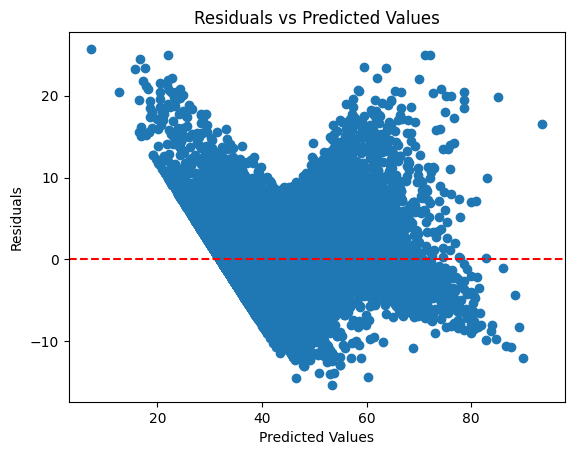

In [65]:
plt.scatter(y_test_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')  # Reference line at zero
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values")
plt.show()

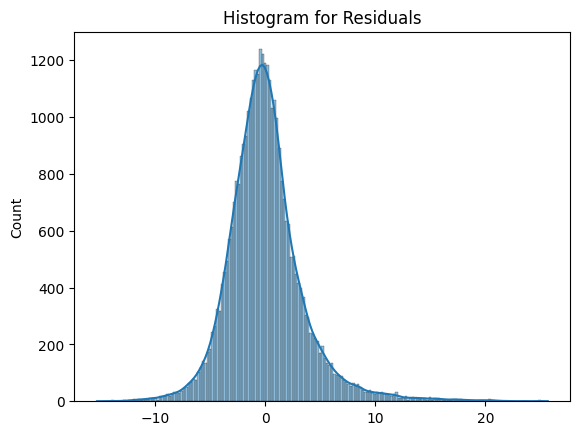

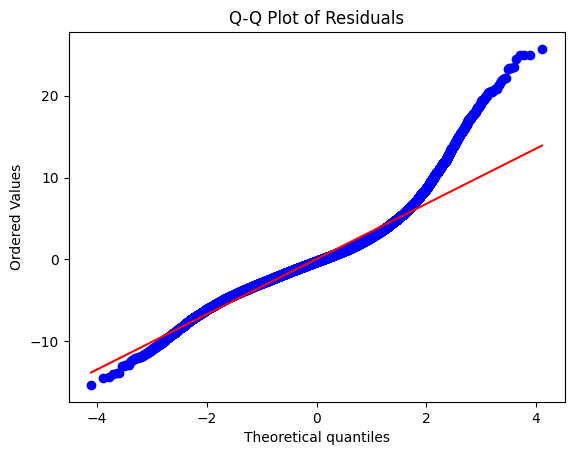

In [68]:
#Histogram for Residuals and Q-Q Plot 
sns.histplot(residuals, kde=True)
plt.title("Histogram for Residuals")
plt.show()

stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

[Your inferences here:]



#### **6.2 Perform Coefficient Analysis** <font color = red>[2 marks]</font> <br>

Perform coefficient analysis to find how changes in features affect the target.
Also, the features were scaled, so interpret the scaled and unscaled coefficients to understand the impact of feature changes on delivery time.


In [71]:
print(X_train_num_col_Scale.shape)    
print(X_train_final.shape)   

(140621, 17)
(140621, 17)


In [72]:
y_train_noScale = y_train_num_col_Scale.reset_index(drop=True)
print(X_train_num_col_Scale.index.equals(y_train_noScale.index))

True


In [73]:
# Compare the scaled vs unscaled features used in the final model
import statsmodels.api as sm

Lrsm_unscaled = sm.OLS(y_train_noScale, X_train_num_col_Scale).fit()
coefficients_unscaled  = Lrsm_unscaled.params  # Get feature coefficients
print(coefficients_unscaled)


total_items                 0.324394
subtotal                   -0.000340
num_distinct_items          2.635035
max_item_price              0.008569
total_onshift_dashers      -0.319531
total_busy_dashers         -0.072736
total_outstanding_orders    0.324536
distance                    0.849641
order_hour                  0.091534
market_id_2.0              -1.534879
market_id_3.0               2.239017
market_id_6.0               2.012263
order_day_of_week_1         7.807836
order_day_of_week_2         7.674343
order_day_of_week_3         8.063650
order_day_of_week_4         8.410527
isWeekend_1                 8.552976
dtype: float64


Additionally, we can analyse the effect of a unit change in a feature. In other words, because we have scaled the features, a unit change in the features will not translate directly to the model. Use scaled and unscaled coefficients to find how will a unit change in a feature affect the target.

In [74]:
coefficients_scaled = pd.Series(Lrsm_model_2.params, index = X_train_sm.columns)
print(coefficients_scaled)

const                       48.049142
total_items                 -0.134558
subtotal                     2.291121
num_distinct_items           0.883527
max_item_price               0.435430
total_onshift_dashers      -14.974641
total_outstanding_orders    16.212413
distance                     4.203341
order_hour                  -2.221204
market_id_2.0               -2.078031
market_id_3.0               -1.920737
order_day_of_week_1         -2.619511
order_day_of_week_2         -2.277526
order_day_of_week_3         -1.708344
order_day_of_week_4         -0.634225
isWeekend_1                 -0.239328
dtype: float64


In [75]:
# Analyze the effect of a unit change in a feature, say 'total_items'
compare_coeffs = pd.DataFrame({  
    "Coefficient (Unscaled)": coefficients_unscaled,
    "Coefficient (Scaled)": coefficients_scaled
})

print(compare_coeffs.sort_values(by="Coefficient (Scaled)", ascending=False))


                          Coefficient (Unscaled)  Coefficient (Scaled)
const                                        NaN             48.049142
total_outstanding_orders                0.324536             16.212413
distance                                0.849641              4.203341
subtotal                               -0.000340              2.291121
num_distinct_items                      2.635035              0.883527
max_item_price                          0.008569              0.435430
total_items                             0.324394             -0.134558
isWeekend_1                             8.552976             -0.239328
order_day_of_week_4                     8.410527             -0.634225
order_day_of_week_3                     8.063650             -1.708344
market_id_3.0                           2.239017             -1.920737
market_id_2.0                          -1.534879             -2.078031
order_hour                              0.091534             -2.221204
order_

In [77]:
# Get original feature statistics (mean & std before scaling)
feature_means = X_train_num_col_Scale.mean()
feature_stds = X_train_num_col_Scale.std()

print("Feature_means:\n", feature_means)
print("\nFeature_stds:\n", feature_stds)

Feature_means:
 total_items                    3.204358
subtotal                    2697.092604
num_distinct_items             2.673548
max_item_price              1160.720468
total_onshift_dashers         44.947184
total_busy_dashers            41.854303
total_outstanding_orders      58.231374
distance                      21.833790
order_hour                     8.473365
market_id_2.0                  0.305502
market_id_3.0                  0.120160
market_id_6.0                  0.003605
order_day_of_week_1            0.122215
order_day_of_week_2            0.123908
order_day_of_week_3            0.128722
order_day_of_week_4            0.142738
isWeekend_1                    0.345482
dtype: float64

Feature_stds:
 total_items                    2.718707
subtotal                    1830.073210
num_distinct_items             1.624359
max_item_price               564.134123
total_onshift_dashers         34.555492
total_busy_dashers            32.141913
total_outstanding_orders      52.

Note:
The coefficients on the original scale might differ greatly in magnitude from the scaled coefficients, but they both describe the same relationships between variables.

Interpretation is key: Focus on the direction and magnitude of the coefficients on the original scale to understand the impact of each variable on the response variable in the original units.

Include conclusions in your report document.

# Analyze the effect of a unit change in a feature, say 'total_items'

#Scaled coefficient of total_items is equal to --> -0.134558
# Std deviation of total_items from unscaled feature set is equal to --> 2.718707

#1-unit increase in total_items = (Scaled coefficient of total_items ) * (Std deviation of unscaled total_items)

#A 1-unit increase in total_items increases delivery_time_taken by :
-0.12 × 2.71 = ~0.35 minutes.


## Subjective Questions <font color = red>[20 marks]</font>

Answer the following questions only in the notebook. Include the visualisations/methodologies/insights/outcomes from all the above steps in your report.

#### Subjective Questions based on Assignment

##### **Question 1.** <font color = red>[2 marks]</font> <br>

Are there any categorical variables in the data? From your analysis of the categorical variables from the dataset, what could you infer about their effect on the dependent variable?

**Answer:**
> In the dataset, there are categorical variables such as "day_of_week_4" and "market_id_3.0" that exhibit a negative correlation with the target variable. However, due to their relatively small effect size, these variables have minimal impact on the target variable. Consequently, dropping these variables is unlikely to significantly affect the overall performance of the model.



---



##### **Question 2.** <font color = red>[1 marks]</font> <br>
What does `test_size = 0.2` refer to during splitting the data into training and test sets?

**Answer:**
> The parameter test_size=0.2 indicates that 20% of the entire dataset will be allocated to the test set. This means that the remaining 80% of the data will be used for training the model. This split is crucial for evaluating the model's performance on unseen data, ensuring that it generalizes well beyond the training set.



---



##### **Question 3.** <font color = red>[1 marks]</font> <br>
Looking at the heatmap, which one has the highest correlation with the target variable?  

**Answer:**
> According to the heatmap, the variable "distance" exhibits the highest correlation with the target variable, with a correlation coefficient of 0.46. This suggests a moderate positive relationship, indicating that as the distance increases, the target variable tends to increase as well.



---



##### **Question 4.** <font color = red>[2 marks]</font> <br>
What was your approach to detect the outliers? How did you address them?

**Answer:**

> **1. Handling Negative Values in Dashers/Orders:**
Negative values for delivery partners and orders are considered incorrect and treated as outliers. To address this, I applied the np.abs() function to the following variables: 
> 1. total_onshift_dashers
> 2. total_busy_dashers
> 3. total_outstanding_orders. 

> This approach converts negative values to their absolute values, making them positive and more meaningful for analysis.

> **2. Subtotal Analysis:** The subtotal data contains both high and low values, which appear to be valid based on factors such as the number of items ordered and the recorded delivery time. Therefore, I have considered these values as legitimate. Additionally, the subtotal includes zero values. I chose to retain these entries, as they may indicate instances where discounts or coupons were applied, resulting in a zero bill. There are approximately 100 rows with zero values, and removing them negatively impacts the model's performance. Thus, I have deemed these entries as critical data and kept them unchanged.



---



##### **Question 5.** <font color = red>[2 marks]</font> <br>
Based on the final model, which are the top 3 features significantly affecting the delivery time?

**Answer:**
> The top three features significantly affecting delivery time, based on the final model and the magnitude of their coefficients, are as follows:
> 1. Total Outstanding Orders
> 2. Total Onshift Dashers
> 3. Distance



---



#### General Subjective Questions

##### **Question 6.** <font color = red>[3 marks]</font> <br>
Explain the linear regression algorithm in detail

**Answer:**
> Linear regression is a predictive modeling technique in machine learning that models the relationship between independent variables and a dependent variable using a straight-line equation, represented as follows:

[ y = mx + c ]

Where:

1. ( y ) → Dependent variable (Target variable)
2. ( x ) → Independent variable (Feature variable)
3. ( m ) → Slope (indicates how much ( y ) changes when ( x ) increases by 1)
4. ( c ) → Intercept (the value of ( y ) when ( x = 0)

> Steps of the Algorithm:

1. Initialize the Model: The algorithm assumes a linear relationship between input features and the target output.

2. Estimate the Best Fit Line (Training Process): The model adjusts coefficients ( w_1, w_2, \ldots, w_n ) to minimize the error (cost function).

3. Once Trained: The model uses the equation ( y = mx + c ) to predict ( y ) for any new input ( x ).

4. Evaluate Model Performance: Metrics like Mean Squared Error (MSE) and R² Score help determine accuracy.

5. Optimization: Finding the Best Line: Linear regression uses Least Squares Optimization to find the best-fit line by minimizing the sum of squared errors (SSE):
   [ SSE = \sum (y_{{actual}} - y_{{predicted}})^2 ]
   The algorithm updates weights using Gradient Descent, adjusting them iteratively to reduce errors.

> Key Assumptions of Linear Regression:
1. Linearity: The relationship between features and the target should be linear.

2. Independence: Features should not be highly correlated (to avoid/minimize multicollinearity).

3. Normality of Errors: Residuals (differences between actual and predicted values) should be normally distributed.

4. Constant Variance (Homoscedasticity): Errors should remain consistent across all values.






---



##### **Question 7.** <font color = red>[2 marks]</font> <br>
Explain the difference between simple linear regression and multiple linear regression

**Answer:**
> Simple Linear Regression describes the relationship between a single independent variable and a single dependent variable using a straight-line equation. It aims to model how the dependent variable changes as the independent variable changes, providing a clear and straightforward interpretation of their relationship.

> Multiple Linear Regression expands on Simple Linear Regression by incorporating two or more independent variables to predict the dependent variable. This approach allows for a more comprehensive analysis, as it considers multiple factors that may influence the dependent variable, providing a better understanding of the relationships among the variables.



---



##### **Question 8.** <font color = red>[2 marks]</font> <br>
What is the role of the cost function in linear regression, and how is it minimized?

**Answer:**
> The cost function measures how well a linear regression model predicts the actual values. Lower values of the cost function indicate better model performance. A common example of a cost function used in linear regression is the Mean Squared Error (MSE), which quantifies the average squared difference between the predicted and actual values.

> Minimization of the Cost Function: The cost function is minimized using the following methods:
1. Gradient Descent Algorithm: This iterative optimization technique adjusts the slopes and intercepts of the model to minimize the MSE. It updates the model parameters in the direction of the steepest descent of the cost function.

2. Normal Equation (For Least Squares Optimization): This method directly solves for the optimal weights without the need for iteration. It provides a closed-form solution to find the coefficients that minimize the cost function.




---



##### **Question 9.** <font color = red>[2 marks]</font> <br>
Explain the difference between overfitting and underfitting.



**Answer:**

> Overfitting occurs when a model learns the training data too well, including its noise and outliers. As a result, the model performs exceptionally on the training set but fails to generalize to unseen or test data, leading to poor performance on new inputs.

> Underfitting happens when a model is too simple to capture the underlying patterns in the data. This results in poor performance on both the training and test sets, as the model cannot adequately learn from the data.



---



##### **Question 10.** <font color = red>[3 marks]</font> <br>
How do residual plots help in diagnosing a linear regression model?

**Answer:**
> Residual plots visualize the differences between actual and predicted values, helping assess the quality and reliability of a regression model. They offer insights into patterns that might indicate potential problems with the model.

Key Uses of Residual Plots:
  1. Identify Non-Linearity: If the residuals display a curved pattern, it suggests that the model is failing to capture a non-linear relationship in the data. This indicates a need for a    more complex or transformed model.
  2. Detect Heteroscedasticity (Unequal Error Variance): If the spread of residuals increases with the predicted values, it points to heteroscedasticity. This means the model’s error variance is not constant, which can affect prediction confidence.
  3. Expose Systematic Bias: Residuals that consistently fall above or below the zero line suggest the model is systematically overestimating or underestimating predictions. This can highlight missing variables or model mis-specification.
  4. Verify Randomness of Errors: Ideally, residuals should be randomly scattered around the zero line. A random distribution indicates that the model has captured the data structure well, and that residuals are not correlated with predictions.

